In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [44]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict, namedtuple
import itertools


import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import colorcet as cc
import cv2
import pandas as pd

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import tabulate

from quinn_embedding_stimuli import *
from quinn_embedding_models import *
from quinn_embedding_triplets import *
from quinn_embedding_task import *
from quinn_embedding_tables import *
from quinn_embedding_visualizations import *


In [3]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

## Object generator and sample

In [5]:
def plot_generator_examples(generator):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((30, 30 + (i * 30)), reference_positions, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

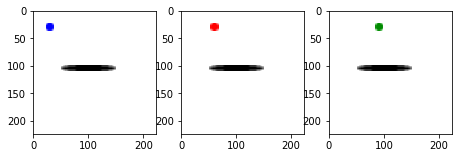

In [6]:
target_size = 15
reference_size = (10, 100)
reference_positions = [(105, 100)]

blue_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='blue')
red_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='red')
green_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='green')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
gen = PatchStimulusGenerator(target_size, reference_size, [blue_target_patch, red_target_patch, green_target_patch], 
                             reference_patch, blur_func=blur_func)

plot_generator_examples(gen)

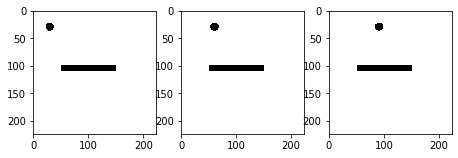

In [242]:
target_size = 15
reference_size = (10, 100)
target_patch_1 = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
target_patch_2 = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
target_patch_3 = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
rectangle_reference_patch = matplotlib.patches.Rectangle(
    (-reference_size[1] // 2, -reference_size[0] // 2), reference_size[1], reference_size[0], color='black')


# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
dot_and_bar_gen = PatchStimulusGenerator(target_size, reference_size, 
                                         [target_patch_1, target_patch_2, target_patch_3], 
                                         rectangle_reference_patch)

plot_generator_examples(dot_and_bar_gen)

In [ ]:
target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
same_color_gen = PatchStimulusGenerator(target_size, reference_size, [target_patch], 
                                        reference_patch, blur_func=blur_func)

plot_generator_examples(same_color_gen)

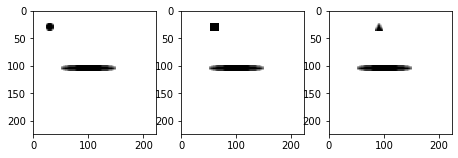

In [8]:
target_size = 15
reference_size = (10, 100)
reference_positions = [(105, 100)]

circle_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
square_patch = matplotlib.patches.Rectangle((-target_size // 2, -target_size // 2), target_size, target_size, color='black')
triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size // 2, color='black')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
different_shapes_gen = PatchStimulusGenerator(target_size, reference_size, 
                                              [circle_patch, square_patch, triangle_patch], 
                                              reference_patch, blur_func=blur_func)

plot_generator_examples(different_shapes_gen)

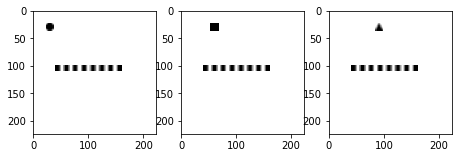

In [9]:
target_size = 15
reference_box_size = 10
total_reference_size = (10, 120)
reference_positions = [(105, 100)]

circle_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
square_patch = matplotlib.patches.Rectangle((-target_size // 2, -target_size // 2), target_size, target_size, color='black')
triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size // 2, color='black')

reference_patches = [matplotlib.patches.Rectangle(((-reference_box_size // 2) + (reference_box_size * 2 * i), 
                                                   (-reference_box_size // 2)), 
                                                  reference_box_size, reference_box_size, color='black')
                    for i in range(8)]


blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
split_reference_gen = PatchStimulusGenerator(target_size, total_reference_size, 
                                              [circle_patch, square_patch, triangle_patch], 
                                              reference_patches, blur_func=blur_func,
                                              reference_patch_kwargs=dict(ylim=(-70, 70)))

plot_generator_examples(split_reference_gen)

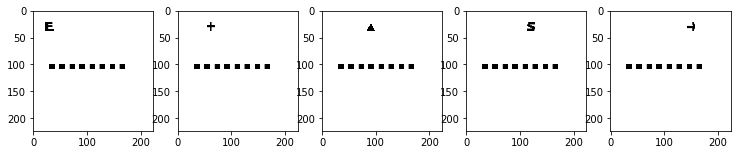

In [10]:
target_size = (15, 15)
reference_box_size = 10
total_reference_size = (10, 140)
reference_positions = [(105, 100)]

triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size[0] // 2, color='black')

reference_patches = [matplotlib.patches.Rectangle(((-reference_box_size // 2) + (reference_box_size * 2 * i), 
                                                   (-reference_box_size // 2)), 
                                                  reference_box_size, reference_box_size, color='black')
                    for i in range(8)]


blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
split_reference_text_gen = PatchStimulusGenerator(target_size, total_reference_size, 
                                              ['E', '$+$', triangle_patch, 's', '$\\to$'], 
                                              reference_patches, # blur_func=blur_func,
                                              reference_patch_kwargs=dict(ylim=(-70, 70)))

plot_generator_examples(split_reference_text_gen)

## Triplet generators

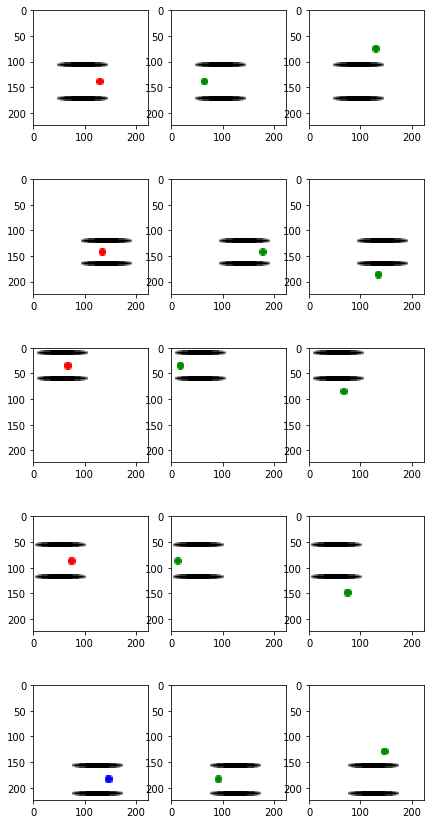

In [12]:
N = 5

above_below_quinn_gen = QuinnTripletGenerator(gen, (30, 70), two_reference_objects=True, n_target_types=2)
results = above_below_quinn_gen(N, normalize=False)
plt.figure(figsize=(7, 3 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()


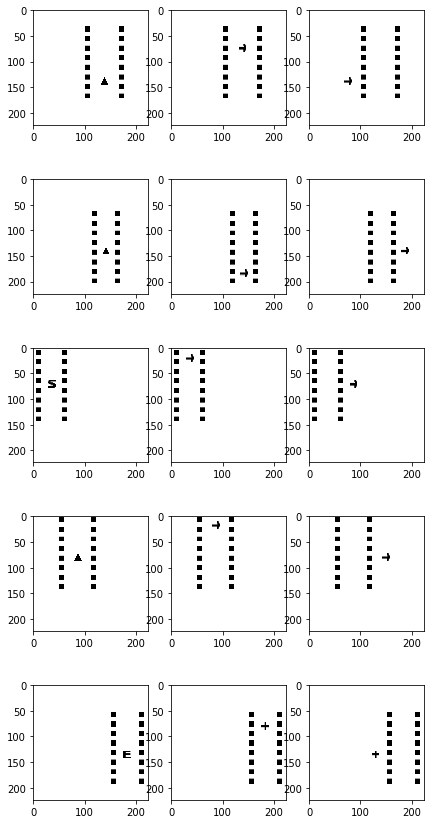

In [154]:
N = 5

above_below_quinn_gen = QuinnTripletGenerator(split_reference_text_gen, (30, 70), 
                                              two_reference_objects=True, 
                                              n_target_types=2, transpose=True)
results = above_below_quinn_gen(N, normalize=False)
plt.figure(figsize=(7, 3 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()


## Metric functions

## Actual task implementation

In [17]:
def default_name_func(generator_kwargs, base_name=''):
    two_reference_objects = generator_kwargs['two_reference_objects']
    transpose = generator_kwargs['transpose']
    
    if two_reference_objects:
        if transpose:
            rel_name = 'VerticalBetween'
        else:
            rel_name = 'Between'
    else:
        if transpose:
            rel_name = 'Left/Right'
        else:
            rel_name = 'Above/Below'
    
    name = f'{base_name}{base_name and "-" or ""}{rel_name}'
            
    n_target_types = None
    if 'n_target_types' in generator_kwargs:
        n_target_types = generator_kwargs['n_target_types']
        return name + f'-{n_target_types}-types'
    
    return name


def create_generators_and_names(triplet_generator_class, stimulus_generator, kwarg_value_sets, 
                                name_func=default_name_func, name_func_kwargs=None):
    if name_func_kwargs is None:
        name_func_kwargs = {}
    
    names = []
    triplet_generators = []

    for value_set in itertools.product(*kwarg_value_sets.values()):
        kwargs = {k: v for (k, v) in zip(kwarg_value_sets.keys(), value_set)}
        names.append(name_func(kwargs, **name_func_kwargs))
        triplet_generators.append(triplet_generator_class(stimulus_generator, **kwargs))

    return names, triplet_generators
    

In [18]:
QUINN_DISTANCE_ENDPOINTS = (30, 70)

quinn_default_value_sets = dict(
    distance_endpoints=(QUINN_DISTANCE_ENDPOINTS,),
    two_reference_objects=(False, True),
    transpose=(False, True),
    n_target_types=range(1, 4)
)

quinn_names, quinn_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn'))

In [19]:
model_kwarg_dicts = (
    dict(name=MOBILENET, device=device, pretrained=False, saycam='S'),
    dict(name=MOBILENET, device=device, pretrained=True),
    dict(name=MOBILENET, device=device, pretrained=False),
    dict(name=RESNEXT, device=device, pretrained=False, saycam='S'),
    dict(name=RESNEXT, device=device, pretrained=True),
    dict(name=RESNEXT, device=device, pretrained=False),
)

model_names = [ f'{d["name"]}-{"saycam" in d and "saycam(S)" or (d["pretrained"] and "imagenet" or "random")}'
               for d in model_kwarg_dicts]


In [20]:
N = 1024
quinn_generators_all_model_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_names, quinn_triplet_generators, N)

Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random


In [21]:
display_multiple_model_results_multiple_types('Quinn', quinn_generators_all_model_results, tablefmt='github')

## Quinn Results

### Quinn-Above/Below

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $1.0000 \pm 0.0000$                                                                            | $0.0674 \pm 0.0007$                                                                              |
|                1 | mobilenet-imagenet  | $0.9346 \pm 0.0077$                                                                            | $0.0420 \pm 0.0008$                                                                              |
|                1 | mobilenet-random    | $0.4844 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam(S)   | $1.0000 \pm 0.0000$                                                                            | $0.1705 \pm 0.0016$                                                                              |
|                1 | resnext-imagenet    | $0.8916 \pm 0.0097$                                                                            | $0.0332 \pm 0.0010$                                                                              |
|                1 | resnext-random      | $0.6230 \pm 0.0151$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.9971 \pm 0.0017$                                                                            | $0.0620 \pm 0.0007$                                                                              |
|                2 | mobilenet-imagenet  | $0.8213 \pm 0.0120$                                                                            | $0.0322 \pm 0.0011$                                                                              |
|                2 | mobilenet-random    | $0.5039 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $1.0000 \pm 0.0000$                                                                            | $0.1639 \pm 0.0016$                                                                              |
|                2 | resnext-imagenet    | $0.7021 \pm 0.0143$                                                                            | $0.0185 \pm 0.0014$                                                                              |
|                2 | resnext-random      | $0.5967 \pm 0.0153$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.9961 \pm 0.0019$                                                                            | $0.0625 \pm 0.0008$                                                                              |
|                3 | mobilenet-imagenet  | $0.8271 \pm 0.0118$                                                                            | $0.0352 \pm 0.0011$                                                                              |
|                3 | mobilenet-random    | $0.4932 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam(S)   | $1.0000 \pm 0.0000$                                                                            | $0.1661 \pm 0.0016$                                                                              |
|                3 | resnext-imagenet    | $0.6914 \pm 0.0144$                                                                            | $0.0183 \pm 0.0013$                                                                              |
|                3 | resnext-random      | $0.5859 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Left/Right

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.6006 \pm 0.0153$                                                                            | $0.0019 \pm 0.0003$                                                                              |
|                1 | mobilenet-imagenet  | $0.3311 \pm 0.0147$                                                                            | $-0.0065 \pm 0.0005$                                                                             |
|                1 | mobilenet-random    | $0.4756 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam(S)   | $0.1475 \pm 0.0111$                                                                            | $-0.0275 \pm 0.0008$                                                                             |
|                1 | resnext-imagenet    | $0.1533 \pm 0.0113$                                                                            | $-0.0231 \pm 0.0007$                                                                             |
|                1 | resnext-random      | $0.5576 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.5586 \pm 0.0155$                                                                            | $0.0012 \pm 0.0004$                                                                              |
|                2 | mobilenet-imagenet  | $0.3945 \pm 0.0153$                                                                            | $-0.0053 \pm 0.0008$                                                                             |
|                2 | mobilenet-random    | $0.5059 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $0.1387 \pm 0.0108$                                                                            | $-0.0275 \pm 0.0008$                                                                             |
|                2 | resnext-imagenet    | $0.2637 \pm 0.0138$                                                                            | $-0.0197 \pm 0.0011$                                                                             |
|                2 | resnext-random      | $0.5273 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.5488 \pm 0.0156$                                                                            | $0.0012 \pm 0.0005$                                                                              |
|                3 | mobilenet-imagenet  | $0.4473 \pm 0.0155$                                                                            | $-0.0051 \pm 0.0009$                                                                             |
|                3 | mobilenet-random    | $0.4736 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam(S)   | $0.1641 \pm 0.0116$                                                                            | $-0.0263 \pm 0.0008$                                                                             |
|                3 | resnext-imagenet    | $0.3242 \pm 0.0146$                                                                            | $-0.0189 \pm 0.0012$                                                                             |
|                3 | resnext-random      | $0.5127 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Between

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.9678 \pm 0.0055$                                                                            | $0.0220 \pm 0.0004$                                                                              |
|                1 | mobilenet-imagenet  | $0.9004 \pm 0.0094$                                                                            | $0.0225 \pm 0.0006$                                                                              |
|                1 | mobilenet-random    | $0.5664 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.9922 \pm 0.0028$                                                                            | $0.0641 \pm 0.0012$                                                                              |
|                1 | resnext-imagenet    | $0.6738 \pm 0.0147$                                                                            | $0.0068 \pm 0.0006$                                                                              |
|                1 | resnext-random      | $0.5225 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.9609 \pm 0.0061$                                                                            | $0.0215 \pm 0.0004$                                                                              |
|                2 | mobilenet-imagenet  | $0.8057 \pm 0.0124$                                                                            | $0.0187 \pm 0.0007$                                                                              |
|                2 | mobilenet-random    | $0.5352 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $0.9844 \pm 0.0039$                                                                            | $0.0613 \pm 0.0011$                                                                              |
|                2 | resnext-imagenet    | $0.4434 \pm 0.0155$                                                                            | $-0.0034 \pm 0.0010$                                                                             |
|                2 | resnext-random      | $0.5693 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.9365 \pm 0.0076$                                                                            | $0.0210 \pm 0.0004$                                                                              |
|                3 | mobilenet-imagenet  | $0.7734 \pm 0.0131$                                                                            | $0.0203 \pm 0.0008$                                                                              |
|                3 | mobilenet-random    | $0.5801 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.9834 \pm 0.0040$                                                                            | $0.0619 \pm 0.0012$                                                                              |
|                3 | resnext-imagenet    | $0.4629 \pm 0.0156$                                                                            | $-0.0041 \pm 0.0009$                                                                             |
|                3 | resnext-random      | $0.5508 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-VerticalBetween

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.6768 \pm 0.0146$                                                                            | $0.0029 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet  | $0.3896 \pm 0.0152$                                                                            | $-0.0033 \pm 0.0004$                                                                             |
|                1 | mobilenet-random    | $0.5098 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.2178 \pm 0.0129$                                                                            | $-0.0248 \pm 0.0009$                                                                             |
|                1 | resnext-imagenet    | $0.0947 \pm 0.0092$                                                                            | $-0.0265 \pm 0.0007$                                                                             |
|                1 | resnext-random      | $0.4834 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | mobilenet-saycam(S) | $0.7158 \pm 0.0141$                                                                            | $0.0041 \pm 0.0002$                                                                              |
|                2 | mobilenet-imagenet  | $0.4219 \pm 0.0154$                                                                            | $-0.0028 \pm 0.0006$                                                                             |
|                2 | mobilenet-random    | $0.5566 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $0.1895 \pm 0.0122$                                                                            | $-0.0264 \pm 0.0009$                                                                             |
|                2 | resnext-imagenet    | $0.1133 \pm 0.0099$                                                                            | $-0.0310 \pm 0.0008$                                                                             |
|                2 | resnext-random      | $0.5176 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.6904 \pm 0.0144$                                                                            | $0.0040 \pm 0.0003$                                                                              |
|                3 | mobilenet-imagenet  | $0.4502 \pm 0.0155$                                                                            | $-0.0024 \pm 0.0007$                                                                             |
|                3 | mobilenet-random    | $0.4795 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam(S)   | $0.2002 \pm 0.0125$                                                                            | $-0.0253 \pm 0.0009$                                                                             |
|                3 | resnext-imagenet    | $0.1768 \pm 0.0119$                                                                            | $-0.0315 \pm 0.0010$                                                                             |
|                3 | resnext-random      | $0.4834 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

In [22]:
quinn_single_color_value_sets = dict(
    distance_endpoints=(QUINN_DISTANCE_ENDPOINTS,),
    two_reference_objects=(False, True),
    transpose=(False, True),
)

quinn_single_color_names, quinn_single_color_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, same_color_gen, quinn_single_color_value_sets, name_func_kwargs=dict(base_name='Quinn-Single-Color'))


In [23]:
N = 1024
quinn_generators_single_color_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_single_color_names, quinn_single_color_triplet_generators, N)

Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random


In [24]:
display_multiple_model_results_single_type('Quinn Single Color', quinn_generators_single_color_results, tablefmt='github')

## Quinn Single Color Results

### Quinn-Single-Color-Above/Below

| Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| mobilenet-saycam(S) | $0.9990 \pm 0.0010$                                                                            | $0.0672 \pm 0.0007$                                                                              |
| mobilenet-imagenet  | $0.9229 \pm 0.0083$                                                                            | $0.0318 \pm 0.0007$                                                                              |
| mobilenet-random    | $0.5264 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
| resnext-saycam(S)   | $1.0000 \pm 0.0000$                                                                            | $0.1680 \pm 0.0016$                                                                              |
| resnext-imagenet    | $0.8867 \pm 0.0099$                                                                            | $0.0427 \pm 0.0012$                                                                              |
| resnext-random      | $0.5850 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Single-Color-Left/Right

| Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| mobilenet-saycam(S) | $0.4502 \pm 0.0155$                                                                            | $-0.0008 \pm 0.0003$                                                                             |
| mobilenet-imagenet  | $0.2197 \pm 0.0129$                                                                            | $-0.0144 \pm 0.0006$                                                                             |
| mobilenet-random    | $0.5117 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
| resnext-saycam(S)   | $0.1270 \pm 0.0104$                                                                            | $-0.0284 \pm 0.0009$                                                                             |
| resnext-imagenet    | $0.1270 \pm 0.0104$                                                                            | $-0.0271 \pm 0.0008$                                                                             |
| resnext-random      | $0.6230 \pm 0.0151$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Single-Color-Between

| Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| mobilenet-saycam(S) | $0.9746 \pm 0.0049$                                                                            | $0.0236 \pm 0.0004$                                                                              |
| mobilenet-imagenet  | $0.9033 \pm 0.0092$                                                                            | $0.0213 \pm 0.0006$                                                                              |
| mobilenet-random    | $0.5391 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
| resnext-saycam(S)   | $0.9961 \pm 0.0019$                                                                            | $0.0679 \pm 0.0011$                                                                              |
| resnext-imagenet    | $0.6260 \pm 0.0151$                                                                            | $0.0048 \pm 0.0008$                                                                              |
| resnext-random      | $0.4814 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Single-Color-VerticalBetween

| Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| mobilenet-saycam(S) | $0.6172 \pm 0.0152$                                                                            | $0.0026 \pm 0.0003$                                                                              |
| mobilenet-imagenet  | $0.2725 \pm 0.0139$                                                                            | $-0.0094 \pm 0.0006$                                                                             |
| mobilenet-random    | $0.5273 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
| resnext-saycam(S)   | $0.3115 \pm 0.0145$                                                                            | $-0.0159 \pm 0.0009$                                                                             |
| resnext-imagenet    | $0.1436 \pm 0.0110$                                                                            | $-0.0236 \pm 0.0007$                                                                             |
| resnext-random      | $0.5186 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

In [25]:
quinn_different_shape_names, quinn_different_shape_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, different_shapes_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Diff-Shapes'))

In [26]:
N = 1024
quinn_generators_different_shapes_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_different_shape_names, quinn_different_shape_triplet_generators, N)

Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random


In [27]:
display_multiple_model_results_multiple_types('Quinn Different Shapes', quinn_generators_different_shapes_results, tablefmt='github')

## Quinn Different Shapes Results

### Quinn-Diff-Shapes-Left/Right

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.5479 \pm 0.0156$                                                                            | $0.0014 \pm 0.0003$                                                                              |
|                1 | mobilenet-imagenet  | $0.2393 \pm 0.0133$                                                                            | $-0.0128 \pm 0.0006$                                                                             |
|                1 | mobilenet-random    | $0.5195 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.1904 \pm 0.0123$                                                                            | $-0.0281 \pm 0.0018$                                                                             |
|                1 | resnext-imagenet    | $0.0996 \pm 0.0094$                                                                            | $-0.0295 \pm 0.0008$                                                                             |
|                1 | resnext-random      | $0.6230 \pm 0.0151$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.5479 \pm 0.0156$                                                                            | $0.0008 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet  | $0.3867 \pm 0.0152$                                                                            | $-0.0110 \pm 0.0013$                                                                             |
|                2 | mobilenet-random    | $0.5088 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.3623 \pm 0.0150$                                                                            | $-0.0143 \pm 0.0018$                                                                             |
|                2 | resnext-imagenet    | $0.2129 \pm 0.0128$                                                                            | $-0.0242 \pm 0.0010$                                                                             |
|                2 | resnext-random      | $0.5850 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.5430 \pm 0.0156$                                                                            | $0.0011 \pm 0.0004$                                                                              |
|                3 | mobilenet-imagenet  | $0.4756 \pm 0.0156$                                                                            | $-0.0093 \pm 0.0020$                                                                             |
|                3 | mobilenet-random    | $0.5322 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.4990 \pm 0.0156$                                                                            | $-0.0054 \pm 0.0075$                                                                             |
|                3 | resnext-imagenet    | $0.2598 \pm 0.0137$                                                                            | $-0.0252 \pm 0.0012$                                                                             |
|                3 | resnext-random      | $0.5273 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Diff-Shapes-VerticalBetween

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.6719 \pm 0.0147$                                                                            | $0.0030 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet  | $0.2646 \pm 0.0138$                                                                            | $-0.0084 \pm 0.0005$                                                                             |
|                1 | mobilenet-random    | $0.4463 \pm 0.0155$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam(S)   | $0.2715 \pm 0.0139$                                                                            | $-0.0261 \pm 0.0017$                                                                             |
|                1 | resnext-imagenet    | $0.1123 \pm 0.0099$                                                                            | $-0.0211 \pm 0.0006$                                                                             |
|                1 | resnext-random      | $0.5098 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.6553 \pm 0.0149$                                                                            | $0.0037 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet  | $0.3232 \pm 0.0146$                                                                            | $-0.0097 \pm 0.0008$                                                                             |
|                2 | mobilenet-random    | $0.4287 \pm 0.0155$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.3447 \pm 0.0149$                                                                            | $-0.0208 \pm 0.0017$                                                                             |
|                2 | resnext-imagenet    | $0.1689 \pm 0.0117$                                                                            | $-0.0212 \pm 0.0008$                                                                             |
|                2 | resnext-random      | $0.5645 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.6582 \pm 0.0148$                                                                            | $0.0039 \pm 0.0003$                                                                              |
|                3 | mobilenet-imagenet  | $0.4023 \pm 0.0153$                                                                            | $-0.0082 \pm 0.0010$                                                                             |
|                3 | mobilenet-random    | $0.4844 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam(S)   | $0.4238 \pm 0.0154$                                                                            | $-0.0123 \pm 0.0073$                                                                             |
|                3 | resnext-imagenet    | $0.1953 \pm 0.0124$                                                                            | $-0.0234 \pm 0.0009$                                                                             |
|                3 | resnext-random      | $0.5361 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Diff-Shapes-Above/Below

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $1.0000 \pm 0.0000$                                                                            | $0.0666 \pm 0.0008$                                                                              |
|                1 | mobilenet-imagenet  | $0.9355 \pm 0.0077$                                                                            | $0.0407 \pm 0.0009$                                                                              |
|                1 | mobilenet-random    | $0.4746 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam(S)   | $0.9248 \pm 0.0082$                                                                            | $0.1393 \pm 0.0028$                                                                              |
|                1 | resnext-imagenet    | $0.8770 \pm 0.0103$                                                                            | $0.0375 \pm 0.0011$                                                                              |
|                1 | resnext-random      | $0.6650 \pm 0.0147$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.9951 \pm 0.0022$                                                                            | $0.0593 \pm 0.0008$                                                                              |
|                2 | mobilenet-imagenet  | $0.7061 \pm 0.0142$                                                                            | $0.0189 \pm 0.0012$                                                                              |
|                2 | mobilenet-random    | $0.4980 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $0.8223 \pm 0.0119$                                                                            | $0.0765 \pm 0.0027$                                                                              |
|                2 | resnext-imagenet    | $0.6416 \pm 0.0150$                                                                            | $0.0134 \pm 0.0013$                                                                              |
|                2 | resnext-random      | $0.5566 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.9912 \pm 0.0029$                                                                            | $0.0597 \pm 0.0008$                                                                              |
|                3 | mobilenet-imagenet  | $0.6436 \pm 0.0150$                                                                            | $0.0193 \pm 0.0016$                                                                              |
|                3 | mobilenet-random    | $0.5098 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.5967 \pm 0.0153$                                                                            | $0.0767 \pm 0.0083$                                                                              |
|                3 | resnext-imagenet    | $0.6416 \pm 0.0150$                                                                            | $0.0151 \pm 0.0014$                                                                              |
|                3 | resnext-random      | $0.5117 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Diff-Shapes-Between

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.9580 \pm 0.0063$                                                                            | $0.0214 \pm 0.0004$                                                                              |
|                1 | mobilenet-imagenet  | $0.8408 \pm 0.0114$                                                                            | $0.0179 \pm 0.0006$                                                                              |
|                1 | mobilenet-random    | $0.4639 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam(S)   | $0.8789 \pm 0.0102$                                                                            | $0.0561 \pm 0.0019$                                                                              |
|                1 | resnext-imagenet    | $0.6631 \pm 0.0148$                                                                            | $0.0055 \pm 0.0007$                                                                              |
|                1 | resnext-random      | $0.5371 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.9219 \pm 0.0084$                                                                            | $0.0201 \pm 0.0004$                                                                              |
|                2 | mobilenet-imagenet  | $0.6562 \pm 0.0148$                                                                            | $0.0096 \pm 0.0008$                                                                              |
|                2 | mobilenet-random    | $0.4658 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.5684 \pm 0.0155$                                                                            | $0.0010 \pm 0.0024$                                                                              |
|                2 | resnext-imagenet    | $0.5117 \pm 0.0156$                                                                            | $-0.0006 \pm 0.0008$                                                                             |
|                2 | resnext-random      | $0.5186 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.9189 \pm 0.0085$                                                                            | $0.0201 \pm 0.0005$                                                                              |
|                3 | mobilenet-imagenet  | $0.6025 \pm 0.0153$                                                                            | $0.0099 \pm 0.0009$                                                                              |
|                3 | mobilenet-random    | $0.4932 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam(S)   | $0.4824 \pm 0.0156$                                                                            | $0.0054 \pm 0.0090$                                                                              |
|                3 | resnext-imagenet    | $0.5166 \pm 0.0156$                                                                            | $-0.0016 \pm 0.0009$                                                                             |
|                3 | resnext-random      | $0.5215 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

In [28]:
quinn_split_reference_names, quinn_split_reference_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, split_reference_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Split-Reference'))

In [29]:
N = 1024
quinn_generators_split_reference_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_split_reference_names, quinn_split_reference_triplet_generators, N)

Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random


In [30]:
display_multiple_model_results_multiple_types('Quinn Split Reference', quinn_generators_split_reference_results, tablefmt='github')

## Quinn Split Reference Results

### Quinn-Split-Reference-VerticalBetween

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.7012 \pm 0.0143$                                                                            | $0.0026 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet  | $0.6748 \pm 0.0146$                                                                            | $0.0052 \pm 0.0004$                                                                              |
|                1 | mobilenet-random    | $0.5098 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.6670 \pm 0.0147$                                                                            | $-0.0007 \pm 0.0011$                                                                             |
|                1 | resnext-imagenet    | $0.6289 \pm 0.0151$                                                                            | $0.0035 \pm 0.0003$                                                                              |
|                1 | resnext-random      | $0.5645 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.6953 \pm 0.0144$                                                                            | $0.0031 \pm 0.0002$                                                                              |
|                2 | mobilenet-imagenet  | $0.6426 \pm 0.0150$                                                                            | $0.0053 \pm 0.0005$                                                                              |
|                2 | mobilenet-random    | $0.4785 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.5156 \pm 0.0156$                                                                            | $-0.0145 \pm 0.0016$                                                                             |
|                2 | resnext-imagenet    | $0.5225 \pm 0.0156$                                                                            | $0.0012 \pm 0.0005$                                                                              |
|                2 | resnext-random      | $0.5781 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.7100 \pm 0.0142$                                                                            | $0.0033 \pm 0.0002$                                                                              |
|                3 | mobilenet-imagenet  | $0.6270 \pm 0.0151$                                                                            | $0.0054 \pm 0.0006$                                                                              |
|                3 | mobilenet-random    | $0.5020 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.4678 \pm 0.0156$                                                                            | $-0.0102 \pm 0.0054$                                                                             |
|                3 | resnext-imagenet    | $0.5000 \pm 0.0156$                                                                            | $0.0005 \pm 0.0007$                                                                              |
|                3 | resnext-random      | $0.5029 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Split-Reference-Left/Right

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.7578 \pm 0.0134$                                                                            | $0.0047 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet  | $0.5557 \pm 0.0155$                                                                            | $0.0017 \pm 0.0004$                                                                              |
|                1 | mobilenet-random    | $0.5000 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.2607 \pm 0.0137$                                                                            | $-0.0088 \pm 0.0014$                                                                             |
|                1 | resnext-imagenet    | $0.5303 \pm 0.0156$                                                                            | $0.0017 \pm 0.0004$                                                                              |
|                1 | resnext-random      | $0.6396 \pm 0.0150$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.7129 \pm 0.0141$                                                                            | $0.0035 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet  | $0.4844 \pm 0.0156$                                                                            | $0.0002 \pm 0.0008$                                                                              |
|                2 | mobilenet-random    | $0.4941 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.4121 \pm 0.0154$                                                                            | $-0.0053 \pm 0.0017$                                                                             |
|                2 | resnext-imagenet    | $0.4980 \pm 0.0156$                                                                            | $-0.0002 \pm 0.0008$                                                                             |
|                2 | resnext-random      | $0.6162 \pm 0.0152$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.6982 \pm 0.0143$                                                                            | $0.0038 \pm 0.0003$                                                                              |
|                3 | mobilenet-imagenet  | $0.5205 \pm 0.0156$                                                                            | $0.0005 \pm 0.0011$                                                                              |
|                3 | mobilenet-random    | $0.5088 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.4971 \pm 0.0156$                                                                            | $0.0002 \pm 0.0069$                                                                              |
|                3 | resnext-imagenet    | $0.4961 \pm 0.0156$                                                                            | $0.0011 \pm 0.0011$                                                                              |
|                3 | resnext-random      | $0.5234 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Split-Reference-Above/Below

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.9980 \pm 0.0014$                                                                            | $0.0302 \pm 0.0003$                                                                              |
|                1 | mobilenet-imagenet  | $0.9609 \pm 0.0061$                                                                            | $0.0528 \pm 0.0011$                                                                              |
|                1 | mobilenet-random    | $0.5176 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.9336 \pm 0.0078$                                                                            | $0.0661 \pm 0.0017$                                                                              |
|                1 | resnext-imagenet    | $0.9619 \pm 0.0060$                                                                            | $0.0542 \pm 0.0011$                                                                              |
|                1 | resnext-random      | $0.6426 \pm 0.0150$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.9932 \pm 0.0026$                                                                            | $0.0260 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet  | $0.7070 \pm 0.0142$                                                                            | $0.0268 \pm 0.0018$                                                                              |
|                2 | mobilenet-random    | $0.4922 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.7939 \pm 0.0126$                                                                            | $0.0308 \pm 0.0019$                                                                              |
|                2 | resnext-imagenet    | $0.6836 \pm 0.0145$                                                                            | $0.0242 \pm 0.0015$                                                                              |
|                2 | resnext-random      | $0.5664 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.9941 \pm 0.0024$                                                                            | $0.0260 \pm 0.0003$                                                                              |
|                3 | mobilenet-imagenet  | $0.6260 \pm 0.0151$                                                                            | $0.0261 \pm 0.0022$                                                                              |
|                3 | mobilenet-random    | $0.5078 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.5947 \pm 0.0153$                                                                            | $0.0343 \pm 0.0076$                                                                              |
|                3 | resnext-imagenet    | $0.6465 \pm 0.0149$                                                                            | $0.0244 \pm 0.0017$                                                                              |
|                3 | resnext-random      | $0.5049 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Split-Reference-Between

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.9756 \pm 0.0048$                                                                            | $0.0108 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet  | $0.9424 \pm 0.0073$                                                                            | $0.0448 \pm 0.0012$                                                                              |
|                1 | mobilenet-random    | $0.5215 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.8643 \pm 0.0107$                                                                            | $0.0282 \pm 0.0014$                                                                              |
|                1 | resnext-imagenet    | $0.9189 \pm 0.0085$                                                                            | $0.0280 \pm 0.0008$                                                                              |
|                1 | resnext-random      | $0.5752 \pm 0.0154$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.9414 \pm 0.0073$                                                                            | $0.0093 \pm 0.0002$                                                                              |
|                2 | mobilenet-imagenet  | $0.8896 \pm 0.0098$                                                                            | $0.0428 \pm 0.0013$                                                                              |
|                2 | mobilenet-random    | $0.5176 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $0.6758 \pm 0.0146$                                                                            | $0.0054 \pm 0.0017$                                                                              |
|                2 | resnext-imagenet    | $0.7871 \pm 0.0128$                                                                            | $0.0226 \pm 0.0010$                                                                              |
|                2 | resnext-random      | $0.5508 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.9229 \pm 0.0083$                                                                            | $0.0092 \pm 0.0002$                                                                              |
|                3 | mobilenet-imagenet  | $0.8701 \pm 0.0105$                                                                            | $0.0414 \pm 0.0013$                                                                              |
|                3 | mobilenet-random    | $0.5215 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.5488 \pm 0.0156$                                                                            | $0.0106 \pm 0.0059$                                                                              |
|                3 | resnext-imagenet    | $0.7510 \pm 0.0135$                                                                            | $0.0213 \pm 0.0010$                                                                              |
|                3 | resnext-random      | $0.4932 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

In [31]:
quinn_split_reference_text_names, quinn_split_reference_text_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, split_reference_text_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Split-Reference-Text'))

In [32]:
N = 1024
quinn_generators_split_reference_text_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_split_reference_text_names, quinn_split_reference_text_triplet_generators, N)

Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random


In [33]:
display_multiple_model_results_multiple_types('Quinn Split Reference Text Target', quinn_generators_split_reference_text_results, tablefmt='github')

## Quinn Split Reference Text Target Results

### Quinn-Split-Reference-Text-Left/Right

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.7256 \pm 0.0139$                                                                            | $0.0030 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet  | $0.5732 \pm 0.0155$                                                                            | $0.0030 \pm 0.0004$                                                                              |
|                1 | mobilenet-random    | $0.5098 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.3643 \pm 0.0150$                                                                            | $-0.0026 \pm 0.0002$                                                                             |
|                1 | resnext-imagenet    | $0.6641 \pm 0.0148$                                                                            | $0.0056 \pm 0.0004$                                                                              |
|                1 | resnext-random      | $0.6299 \pm 0.0151$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.6396 \pm 0.0150$                                                                            | $0.0020 \pm 0.0002$                                                                              |
|                2 | mobilenet-imagenet  | $0.5166 \pm 0.0156$                                                                            | $0.0025 \pm 0.0006$                                                                              |
|                2 | mobilenet-random    | $0.4961 \pm 0.0156$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.3730 \pm 0.0151$                                                                            | $-0.0024 \pm 0.0002$                                                                             |
|                2 | resnext-imagenet    | $0.5713 \pm 0.0155$                                                                            | $0.0031 \pm 0.0006$                                                                              |
|                2 | resnext-random      | $0.6357 \pm 0.0150$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.6240 \pm 0.0151$                                                                            | $0.0019 \pm 0.0003$                                                                              |
|                3 | mobilenet-imagenet  | $0.4814 \pm 0.0156$                                                                            | $0.0010 \pm 0.0008$                                                                              |
|                3 | mobilenet-random    | $0.5225 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.3896 \pm 0.0152$                                                                            | $-0.0024 \pm 0.0002$                                                                             |
|                3 | resnext-imagenet    | $0.5469 \pm 0.0156$                                                                            | $0.0027 \pm 0.0007$                                                                              |
|                3 | resnext-random      | $0.6152 \pm 0.0152$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Split-Reference-Text-Between

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.9873 \pm 0.0035$                                                                            | $0.0116 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet  | $0.9648 \pm 0.0058$                                                                            | $0.0366 \pm 0.0009$                                                                              |
|                1 | mobilenet-random    | $0.4102 \pm 0.0154$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam(S)   | $0.9941 \pm 0.0024$                                                                            | $0.0265 \pm 0.0004$                                                                              |
|                1 | resnext-imagenet    | $0.9629 \pm 0.0059$                                                                            | $0.0228 \pm 0.0007$                                                                              |
|                1 | resnext-random      | $0.4053 \pm 0.0153$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | mobilenet-saycam(S) | $0.9766 \pm 0.0047$                                                                            | $0.0113 \pm 0.0002$                                                                              |
|                2 | mobilenet-imagenet  | $0.9346 \pm 0.0077$                                                                            | $0.0366 \pm 0.0010$                                                                              |
|                2 | mobilenet-random    | $0.4336 \pm 0.0155$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.9922 \pm 0.0028$                                                                            | $0.0253 \pm 0.0004$                                                                              |
|                2 | resnext-imagenet    | $0.8545 \pm 0.0110$                                                                            | $0.0212 \pm 0.0009$                                                                              |
|                2 | resnext-random      | $0.4775 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.9795 \pm 0.0044$                                                                            | $0.0113 \pm 0.0002$                                                                              |
|                3 | mobilenet-imagenet  | $0.8877 \pm 0.0099$                                                                            | $0.0374 \pm 0.0012$                                                                              |
|                3 | mobilenet-random    | $0.4238 \pm 0.0154$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam(S)   | $0.9883 \pm 0.0034$                                                                            | $0.0248 \pm 0.0004$                                                                              |
|                3 | resnext-imagenet    | $0.7383 \pm 0.0137$                                                                            | $0.0195 \pm 0.0010$                                                                              |
|                3 | resnext-random      | $0.4424 \pm 0.0155$                                                                            | $-0.0000 \pm 0.0000$                                                                             |

### Quinn-Split-Reference-Text-Above/Below

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.9922 \pm 0.0028$                                                                            | $0.0243 \pm 0.0003$                                                                              |
|                1 | mobilenet-imagenet  | $0.9619 \pm 0.0060$                                                                            | $0.0411 \pm 0.0009$                                                                              |
|                1 | mobilenet-random    | $0.5137 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.9941 \pm 0.0024$                                                                            | $0.0459 \pm 0.0006$                                                                              |
|                1 | resnext-imagenet    | $0.9688 \pm 0.0054$                                                                            | $0.0406 \pm 0.0011$                                                                              |
|                1 | resnext-random      | $0.5967 \pm 0.0153$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.9844 \pm 0.0039$                                                                            | $0.0224 \pm 0.0003$                                                                              |
|                2 | mobilenet-imagenet  | $0.8594 \pm 0.0109$                                                                            | $0.0327 \pm 0.0012$                                                                              |
|                2 | mobilenet-random    | $0.5146 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $0.9834 \pm 0.0040$                                                                            | $0.0407 \pm 0.0006$                                                                              |
|                2 | resnext-imagenet    | $0.7803 \pm 0.0129$                                                                            | $0.0225 \pm 0.0016$                                                                              |
|                2 | resnext-random      | $0.5732 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.9736 \pm 0.0050$                                                                            | $0.0223 \pm 0.0003$                                                                              |
|                3 | mobilenet-imagenet  | $0.7637 \pm 0.0133$                                                                            | $0.0261 \pm 0.0015$                                                                              |
|                3 | mobilenet-random    | $0.5049 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.9814 \pm 0.0042$                                                                            | $0.0373 \pm 0.0006$                                                                              |
|                3 | resnext-imagenet    | $0.6973 \pm 0.0144$                                                                            | $0.0173 \pm 0.0017$                                                                              |
|                3 | resnext-random      | $0.5625 \pm 0.0155$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Split-Reference-Text-VerticalBetween

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.7041 \pm 0.0143$                                                                            | $0.0021 \pm 0.0002$                                                                              |
|                1 | mobilenet-imagenet  | $0.7969 \pm 0.0126$                                                                            | $0.0120 \pm 0.0005$                                                                              |
|                1 | mobilenet-random    | $0.3818 \pm 0.0152$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam(S)   | $0.9404 \pm 0.0074$                                                                            | $0.0068 \pm 0.0002$                                                                              |
|                1 | resnext-imagenet    | $0.7773 \pm 0.0130$                                                                            | $0.0057 \pm 0.0003$                                                                              |
|                1 | resnext-random      | $0.4580 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.7090 \pm 0.0142$                                                                            | $0.0026 \pm 0.0002$                                                                              |
|                2 | mobilenet-imagenet  | $0.7725 \pm 0.0131$                                                                            | $0.0114 \pm 0.0005$                                                                              |
|                2 | mobilenet-random    | $0.3779 \pm 0.0152$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.9238 \pm 0.0083$                                                                            | $0.0067 \pm 0.0002$                                                                              |
|                2 | resnext-imagenet    | $0.5703 \pm 0.0155$                                                                            | $0.0021 \pm 0.0004$                                                                              |
|                2 | resnext-random      | $0.5283 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.7129 \pm 0.0141$                                                                            | $0.0029 \pm 0.0002$                                                                              |
|                3 | mobilenet-imagenet  | $0.7734 \pm 0.0131$                                                                            | $0.0123 \pm 0.0005$                                                                              |
|                3 | mobilenet-random    | $0.4473 \pm 0.0155$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam(S)   | $0.9307 \pm 0.0079$                                                                            | $0.0070 \pm 0.0002$                                                                              |
|                3 | resnext-imagenet    | $0.5010 \pm 0.0156$                                                                            | $-0.0005 \pm 0.0005$                                                                             |
|                3 | resnext-random      | $0.5176 \pm 0.0156$                                                                            | $0.0000 \pm 0.0000$                                                                              |

In [34]:
def build_random_color_stimulus_generator(rng, cmap=cc.cm.glasbey, cmap_range=(0, 255),
                                         target_size=20, reference_size=(10, 100)):
    start_int = rng.integers(cmap_range[0], cmap_range[1] - 4)

    blue_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, 
                                                  color=cmap(start_int))
    red_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2,
                                                 color=cmap(start_int + 1))
    green_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2,
                                                   color=cmap(start_int + 2))
    reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                                 height=reference_size[0], 
                                                 color=cmap(start_int + 3))

    blur_func = lambda x: cv2.blur(x, (5, 5))

    return PatchStimulusGenerator(target_size, reference_size, 
                                  [blue_target_patch, red_target_patch, green_target_patch], 
                                  reference_patch, blur_func=blur_func)


In [35]:
C = 10
N = 1024
all_random_color_names = []
all_random_color_triplet_generators = []
random_color_results = []

for c in range(C):
    print(c)
    rng = np.random.default_rng(c)
    random_gen = build_random_color_stimulus_generator(rng)
    
    random_color_names, random_color_triplet_generators = create_generators_and_names(
        QuinnTripletGenerator, random_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Random-Color'))
    
    all_random_color_names.append(random_color_names)
    all_random_color_triplet_generators.append(random_color_triplet_generators)
    
    random_color_results.append(run_multiple_models_multiple_generators(
        model_names, model_kwarg_dicts, random_color_names, random_color_triplet_generators, N))

0
Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random
1
Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random
2
Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random
3
Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random
4
Starting model mobilenet-saycam(S)
Starting model mobilenet-imagenet
Starting model mobilenet-random
Starting model resnext-saycam(S)
Starting model resnext-imagenet
Starting model resnext-random
5
Starting

In [36]:
display_multiple_model_results_multiple_types_replications('Quinn Random Color Replications', random_color_results)

## Quinn Random Color Replications Results

### Quinn-Random-Color-VerticalBetween

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.4946 \pm 0.0545$                                                                            | $-0.0016 \pm 0.0027$                                                                             |
|                1 | mobilenet-imagenet  | $0.3071 \pm 0.0214$                                                                            | $-0.0107 \pm 0.0014$                                                                             |
|                1 | mobilenet-random    | $0.5077 \pm 0.0184$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.2155 \pm 0.0240$                                                                            | $-0.0302 \pm 0.0033$                                                                             |
|                1 | resnext-imagenet    | $0.2200 \pm 0.0227$                                                                            | $-0.0161 \pm 0.0019$                                                                             |
|                1 | resnext-random      | $0.5022 \pm 0.0084$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.5332 \pm 0.0449$                                                                            | $0.0001 \pm 0.0021$                                                                              |
|                2 | mobilenet-imagenet  | $0.3371 \pm 0.0222$                                                                            | $-0.0107 \pm 0.0015$                                                                             |
|                2 | mobilenet-random    | $0.5074 \pm 0.0168$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $0.1952 \pm 0.0219$                                                                            | $-0.0328 \pm 0.0032$                                                                             |
|                2 | resnext-imagenet    | $0.2343 \pm 0.0236$                                                                            | $-0.0188 \pm 0.0021$                                                                             |
|                2 | resnext-random      | $0.5339 \pm 0.0109$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.5461 \pm 0.0419$                                                                            | $0.0003 \pm 0.0021$                                                                              |
|                3 | mobilenet-imagenet  | $0.3566 \pm 0.0254$                                                                            | $-0.0106 \pm 0.0017$                                                                             |
|                3 | mobilenet-random    | $0.5045 \pm 0.0159$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.2011 \pm 0.0198$                                                                            | $-0.0318 \pm 0.0033$                                                                             |
|                3 | resnext-imagenet    | $0.2753 \pm 0.0310$                                                                            | $-0.0191 \pm 0.0021$                                                                             |
|                3 | resnext-random      | $0.5180 \pm 0.0105$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Random-Color-Above/Below

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.9990 \pm 0.0002$                                                                            | $0.0782 \pm 0.0025$                                                                              |
|                1 | mobilenet-imagenet  | $0.8688 \pm 0.0162$                                                                            | $0.0344 \pm 0.0020$                                                                              |
|                1 | mobilenet-random    | $0.4933 \pm 0.0049$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam(S)   | $1.0000 \pm 0.0000$                                                                            | $0.1735 \pm 0.0029$                                                                              |
|                1 | resnext-imagenet    | $0.9268 \pm 0.0104$                                                                            | $0.0436 \pm 0.0034$                                                                              |
|                1 | resnext-random      | $0.5671 \pm 0.0068$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.9875 \pm 0.0042$                                                                            | $0.0696 \pm 0.0023$                                                                              |
|                2 | mobilenet-imagenet  | $0.7583 \pm 0.0208$                                                                            | $0.0255 \pm 0.0019$                                                                              |
|                2 | mobilenet-random    | $0.5041 \pm 0.0045$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $0.9982 \pm 0.0009$                                                                            | $0.1633 \pm 0.0038$                                                                              |
|                2 | resnext-imagenet    | $0.7779 \pm 0.0214$                                                                            | $0.0299 \pm 0.0036$                                                                              |
|                2 | resnext-random      | $0.5604 \pm 0.0070$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.9734 \pm 0.0104$                                                                            | $0.0695 \pm 0.0025$                                                                              |
|                3 | mobilenet-imagenet  | $0.7185 \pm 0.0229$                                                                            | $0.0269 \pm 0.0019$                                                                              |
|                3 | mobilenet-random    | $0.4962 \pm 0.0057$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam(S)   | $0.9981 \pm 0.0013$                                                                            | $0.1661 \pm 0.0039$                                                                              |
|                3 | resnext-imagenet    | $0.7376 \pm 0.0296$                                                                            | $0.0314 \pm 0.0038$                                                                              |
|                3 | resnext-random      | $0.5323 \pm 0.0078$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Random-Color-Left/Right

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.5537 \pm 0.0424$                                                                            | $0.0014 \pm 0.0017$                                                                              |
|                1 | mobilenet-imagenet  | $0.2768 \pm 0.0234$                                                                            | $-0.0124 \pm 0.0017$                                                                             |
|                1 | mobilenet-random    | $0.4920 \pm 0.0045$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                1 | resnext-saycam(S)   | $0.1384 \pm 0.0078$                                                                            | $-0.0345 \pm 0.0018$                                                                             |
|                1 | resnext-imagenet    | $0.1233 \pm 0.0145$                                                                            | $-0.0269 \pm 0.0023$                                                                             |
|                1 | resnext-random      | $0.5831 \pm 0.0099$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | mobilenet-saycam(S) | $0.5224 \pm 0.0310$                                                                            | $0.0001 \pm 0.0015$                                                                              |
|                2 | mobilenet-imagenet  | $0.2898 \pm 0.0206$                                                                            | $-0.0136 \pm 0.0017$                                                                             |
|                2 | mobilenet-random    | $0.5023 \pm 0.0050$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | resnext-saycam(S)   | $0.1403 \pm 0.0116$                                                                            | $-0.0356 \pm 0.0019$                                                                             |
|                2 | resnext-imagenet    | $0.1948 \pm 0.0176$                                                                            | $-0.0242 \pm 0.0021$                                                                             |
|                2 | resnext-random      | $0.5744 \pm 0.0100$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.5560 \pm 0.0284$                                                                            | $0.0010 \pm 0.0016$                                                                              |
|                3 | mobilenet-imagenet  | $0.3442 \pm 0.0231$                                                                            | $-0.0129 \pm 0.0017$                                                                             |
|                3 | mobilenet-random    | $0.4968 \pm 0.0038$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                3 | resnext-saycam(S)   | $0.1523 \pm 0.0146$                                                                            | $-0.0343 \pm 0.0018$                                                                             |
|                3 | resnext-imagenet    | $0.2524 \pm 0.0269$                                                                            | $-0.0240 \pm 0.0020$                                                                             |
|                3 | resnext-random      | $0.5455 \pm 0.0118$                                                                            | $0.0000 \pm 0.0000$                                                                              |

### Quinn-Random-Color-Between

|   # Target Types | Model               | Accuracy&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    | Difference&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    |
|------------------|---------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
|                1 | mobilenet-saycam(S) | $0.9240 \pm 0.0066$                                                                            | $0.0256 \pm 0.0013$                                                                              |
|                1 | mobilenet-imagenet  | $0.7934 \pm 0.0244$                                                                            | $0.0197 \pm 0.0018$                                                                              |
|                1 | mobilenet-random    | $0.5273 \pm 0.0117$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                1 | resnext-saycam(S)   | $0.9738 \pm 0.0023$                                                                            | $0.0747 \pm 0.0019$                                                                              |
|                1 | resnext-imagenet    | $0.6940 \pm 0.0240$                                                                            | $0.0093 \pm 0.0016$                                                                              |
|                1 | resnext-random      | $0.4831 \pm 0.0050$                                                                            | $-0.0000 \pm 0.0000$                                                                             |
|                2 | mobilenet-saycam(S) | $0.8979 \pm 0.0067$                                                                            | $0.0241 \pm 0.0014$                                                                              |
|                2 | mobilenet-imagenet  | $0.7066 \pm 0.0208$                                                                            | $0.0149 \pm 0.0017$                                                                              |
|                2 | mobilenet-random    | $0.5326 \pm 0.0095$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                2 | resnext-saycam(S)   | $0.9511 \pm 0.0055$                                                                            | $0.0676 \pm 0.0019$                                                                              |
|                2 | resnext-imagenet    | $0.5826 \pm 0.0253$                                                                            | $0.0028 \pm 0.0021$                                                                              |
|                2 | resnext-random      | $0.5178 \pm 0.0052$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | mobilenet-saycam(S) | $0.8729 \pm 0.0162$                                                                            | $0.0236 \pm 0.0013$                                                                              |
|                3 | mobilenet-imagenet  | $0.6691 \pm 0.0206$                                                                            | $0.0163 \pm 0.0018$                                                                              |
|                3 | mobilenet-random    | $0.5267 \pm 0.0130$                                                                            | $0.0000 \pm 0.0000$                                                                              |
|                3 | resnext-saycam(S)   | $0.9447 \pm 0.0071$                                                                            | $0.0675 \pm 0.0019$                                                                              |
|                3 | resnext-imagenet    | $0.5552 \pm 0.0230$                                                                            | $0.0027 \pm 0.0020$                                                                              |
|                3 | resnext-random      | $0.5033 \pm 0.0057$                                                                            | $0.0000 \pm 0.0000$                                                                              |

In [88]:
result_set = (quinn_generators_split_reference_text_results, 
              quinn_generators_different_shapes_results,
              random_color_results)
df = table_per_relation_multiple_results(result_set, print_std=False, tablefmt='latex_raw')

## Above/Below

\begin{tabular}{llllllll}
\hline
 Stimulus Rendering                           & Target Type      & mobilenet-saycam(S)   & resnext-saycam(S)   & mobilenet-imagenet   & resnext-imagenet   & mobilenet-random   & resnext-random   \\
\hline
 \multirow{2}{*}{\textbf{ Quinn-like }}       & Same Target      & $0.9922$              & $0.9941$            & $0.9619$             & $0.9688$           & $0.5137$           & $0.5967$         \\
                                              & Different Target & $0.9844$              & $0.9834$            & $0.8594$             & $0.7803$           & $0.5146$           & $0.5732$         \\
 \multirow{2}{*}{\textbf{ Geometric Shapes }} & Same Target      & $1.0000$              & $0.9248$            & $0.9355$             & $0.8770$           & $0.4746$           & $0.6650$         \\
                                              & Different Target & $0.9951$              & $0.8223$            & $0.7061$             & $0.6416$           & $0.4980$           & $0.5566$         \\
 \multirow{2}{*}{\textbf{ Colors }}           & Same Target      & $0.9990$              & $1.0000$            & $0.8688$             & $0.9268$           & $0.4933$           & $0.5671$         \\
                                              & Different Target & $0.9875$              & $0.9982$            & $0.7583$             & $0.7779$           & $0.5041$           & $0.5604$         \\
\hline
\end{tabular}

## Left/Right

\begin{tabular}{llllllll}
\hline
 Stimulus Rendering                           & Target Type      & mobilenet-saycam(S)   & resnext-saycam(S)   & mobilenet-imagenet   & resnext-imagenet   & mobilenet-random   & resnext-random   \\
\hline
 \multirow{2}{*}{\textbf{ Quinn-like }}       & Same Target      & $0.7256$              & $0.3643$            & $0.5732$             & $0.6641$           & $0.5098$           & $0.6299$         \\
                                              & Different Target & $0.6396$              & $0.3730$            & $0.5166$             & $0.5713$           & $0.4961$           & $0.6357$         \\
 \multirow{2}{*}{\textbf{ Geometric Shapes }} & Same Target      & $0.5479$              & $0.1904$            & $0.2393$             & $0.0996$           & $0.5195$           & $0.6230$         \\
                                              & Different Target & $0.5479$              & $0.3623$            & $0.3867$             & $0.2129$           & $0.5088$           & $0.5850$         \\
 \multirow{2}{*}{\textbf{ Colors }}           & Same Target      & $0.5537$              & $0.1384$            & $0.2768$             & $0.1233$           & $0.4920$           & $0.5831$         \\
                                              & Different Target & $0.5224$              & $0.1403$            & $0.2898$             & $0.1948$           & $0.5023$           & $0.5744$         \\
\hline
\end{tabular}

## Between

\begin{tabular}{llllllll}
\hline
 Stimulus Rendering                           & Target Type      & mobilenet-saycam(S)   & resnext-saycam(S)   & mobilenet-imagenet   & resnext-imagenet   & mobilenet-random   & resnext-random   \\
\hline
 \multirow{2}{*}{\textbf{ Quinn-like }}       & Same Target      & $0.9873$              & $0.9941$            & $0.9648$             & $0.9629$           & $0.4102$           & $0.4053$         \\
                                              & Different Target & $0.9766$              & $0.9922$            & $0.9346$             & $0.8545$           & $0.4336$           & $0.4775$         \\
 \multirow{2}{*}{\textbf{ Geometric Shapes }} & Same Target      & $0.9580$              & $0.8789$            & $0.8408$             & $0.6631$           & $0.4639$           & $0.5371$         \\
                                              & Different Target & $0.9219$              & $0.5684$            & $0.6562$             & $0.5117$           & $0.4658$           & $0.5186$         \\
 \multirow{2}{*}{\textbf{ Colors }}           & Same Target      & $0.9240$              & $0.9738$            & $0.7934$             & $0.6940$           & $0.5273$           & $0.4831$         \\
                                              & Different Target & $0.8979$              & $0.9511$            & $0.7066$             & $0.5826$           & $0.5326$           & $0.5178$         \\
\hline
\end{tabular}

## VerticalBetween

\begin{tabular}{llllllll}
\hline
 Stimulus Rendering                           & Target Type      & mobilenet-saycam(S)   & resnext-saycam(S)   & mobilenet-imagenet   & resnext-imagenet   & mobilenet-random   & resnext-random   \\
\hline
 \multirow{2}{*}{\textbf{ Quinn-like }}       & Same Target      & $0.7041$              & $0.9404$            & $0.7969$             & $0.7773$           & $0.3818$           & $0.4580$         \\
                                              & Different Target & $0.7090$              & $0.9238$            & $0.7725$             & $0.5703$           & $0.3779$           & $0.5283$         \\
 \multirow{2}{*}{\textbf{ Geometric Shapes }} & Same Target      & $0.6719$              & $0.2715$            & $0.2646$             & $0.1123$           & $0.4463$           & $0.5098$         \\
                                              & Different Target & $0.6553$              & $0.3447$            & $0.3232$             & $0.1689$           & $0.4287$           & $0.5645$         \\
 \multirow{2}{*}{\textbf{ Colors }}           & Same Target      & $0.4946$              & $0.2155$            & $0.3071$             & $0.2200$           & $0.5077$           & $0.5022$         \\
                                              & Different Target & $0.5332$              & $0.1952$            & $0.3371$             & $0.2343$           & $0.5074$           & $0.5339$         \\
\hline
\end{tabular}

In [89]:
df.head()

,relation,rendering,n_target_types,model_name,dataset,acc_mean,acc_std,acc_sem
0,above_below,quinn,1,mobilenet,saycam,0.992188,0.088042,0.002751
1,above_below,quinn,1,resnext,saycam,0.994141,0.076322,0.002385
2,above_below,quinn,1,mobilenet,imagenet,0.961914,0.191404,0.005981
3,above_below,quinn,1,resnext,imagenet,0.968750,0.173993,0.005437
4,above_below,quinn,1,mobilenet,random,0.513672,0.499813,0.015619


In [152]:
df.rendering.unique()

array(['quinn', 'shapes', 'colors'], dtype=object)

In [272]:
above_below_df = filter_and_group(df, 
                 {'relation': 'above_below', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'])

between_df = filter_and_group(df, 
                 {'relation': 'between', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'])


horizontal_mean_diff =  between_df.mean() - above_below_df.mean()
horizontal_mean_diff.acc_mean

dataset   model_name  n_target_types
imagenet  mobilenet   1                -0.055762
                      2                -0.008757
          resnext     1                -0.150814
                      2                -0.083659
saycam    mobilenet   1                -0.040625
                      2                -0.056868
          resnext     1                -0.024023
                      2                -0.097428
Name: acc_mean, dtype: float64

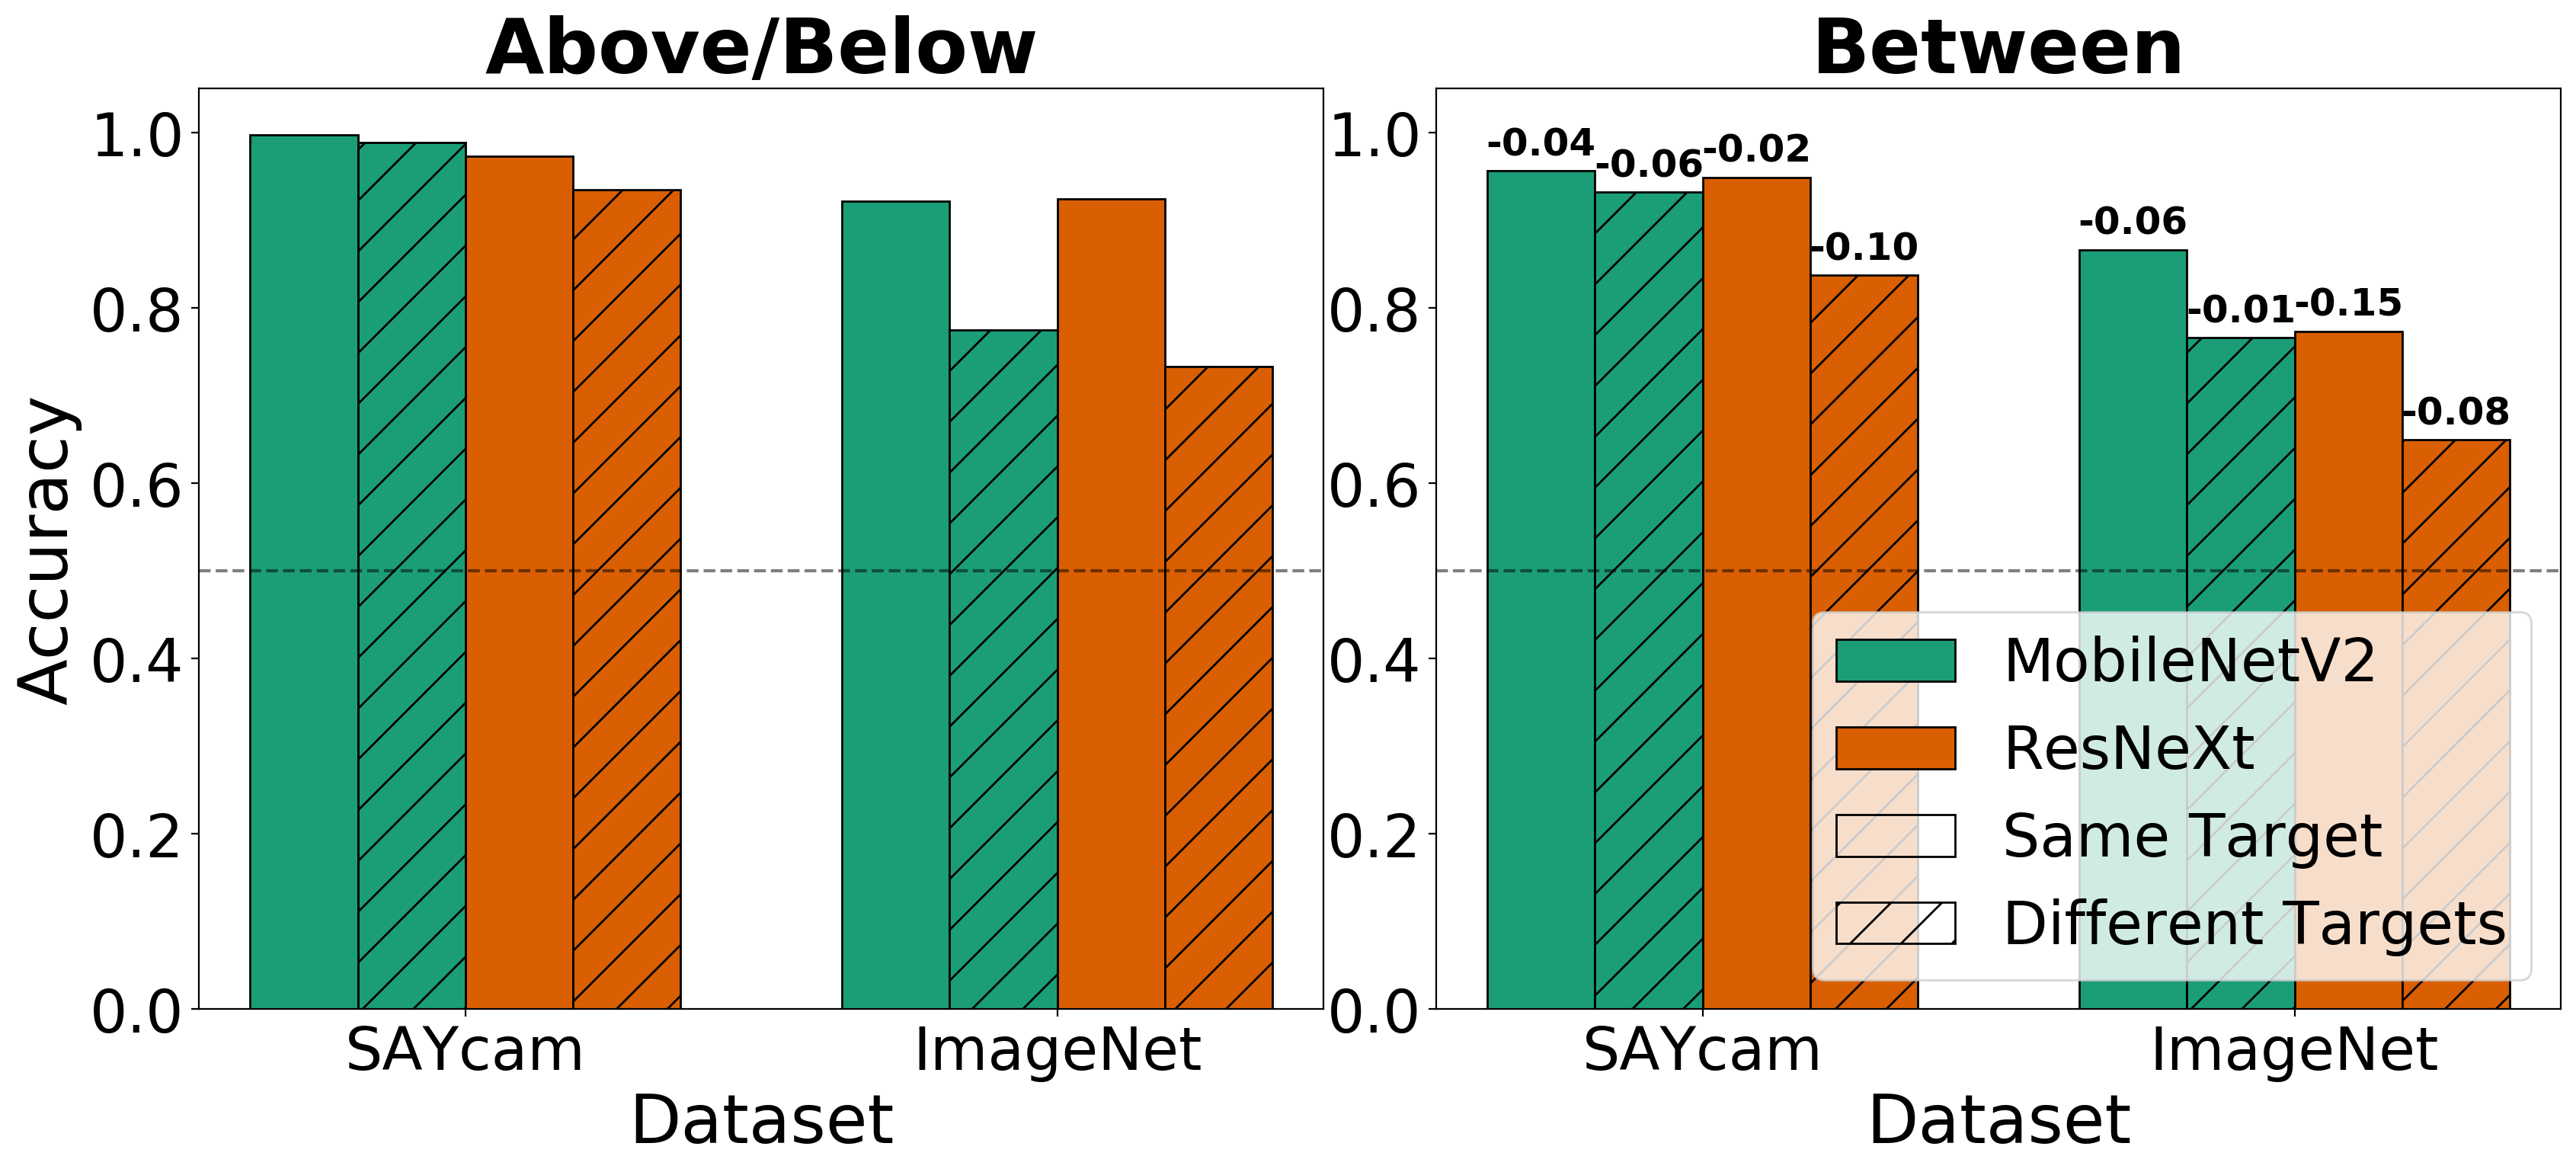

In [276]:
fig = plt.figure(figsize=(20, 8), dpi=200)
fig.subplots_adjust(wspace=0.1)

text_kwargs = {'fontsize': 32}

above_below_ax = plt.subplot(1, 2, 1)
create_bar_chart(df, 
                 {'relation': 'above_below', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'],
                 legend_loc='lower right', plot_std=False,
                 title='Above/Below', legend=False,
                 text_kwargs=text_kwargs, bar_spacing=0.3, 
                 title_kwargs=dict(fontweight='bold'),
                 ax=above_below_ax)

between_ax = plt.subplot(1, 2, 2)
create_bar_chart(df, 
                 {'relation': 'between', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'],
                 legend_loc='lower right', plot_std=False,
                 title='Between', ylabel='', legend_ncol=1,
                 text_kwargs=text_kwargs, bar_spacing=0.3,
                 above_bar_texts=horizontal_mean_diff.acc_mean,
                 above_bar_text_spacing=0.03, above_bar_text_fontsize=18, 
                 title_kwargs=dict(fontweight='bold'),
                 ax=between_ax)

save_plot('exp2_horizontal_reference_bar_charts.pdf')

plt.show()

In [181]:
left_right_df = filter_and_group(df, 
                 {'relation': 'left_right', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'])

vertical_between_df = filter_and_group(df, 
                 {'relation': 'vertical_between', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'])


vertical_mean_diff =  vertical_between_df.mean() - left_right_df.mean()
vertical_mean_diff.acc_mean

dataset   model_name  n_target_types
imagenet  mobilenet   1                 0.093132
                      2                 0.079883
          resnext     1                 0.074219
                      2                -0.001823
saycam    mobilenet   1                 0.014486
                      2                 0.062533
          resnext     1                 0.244792
                      2                 0.196029
Name: acc_mean, dtype: float64

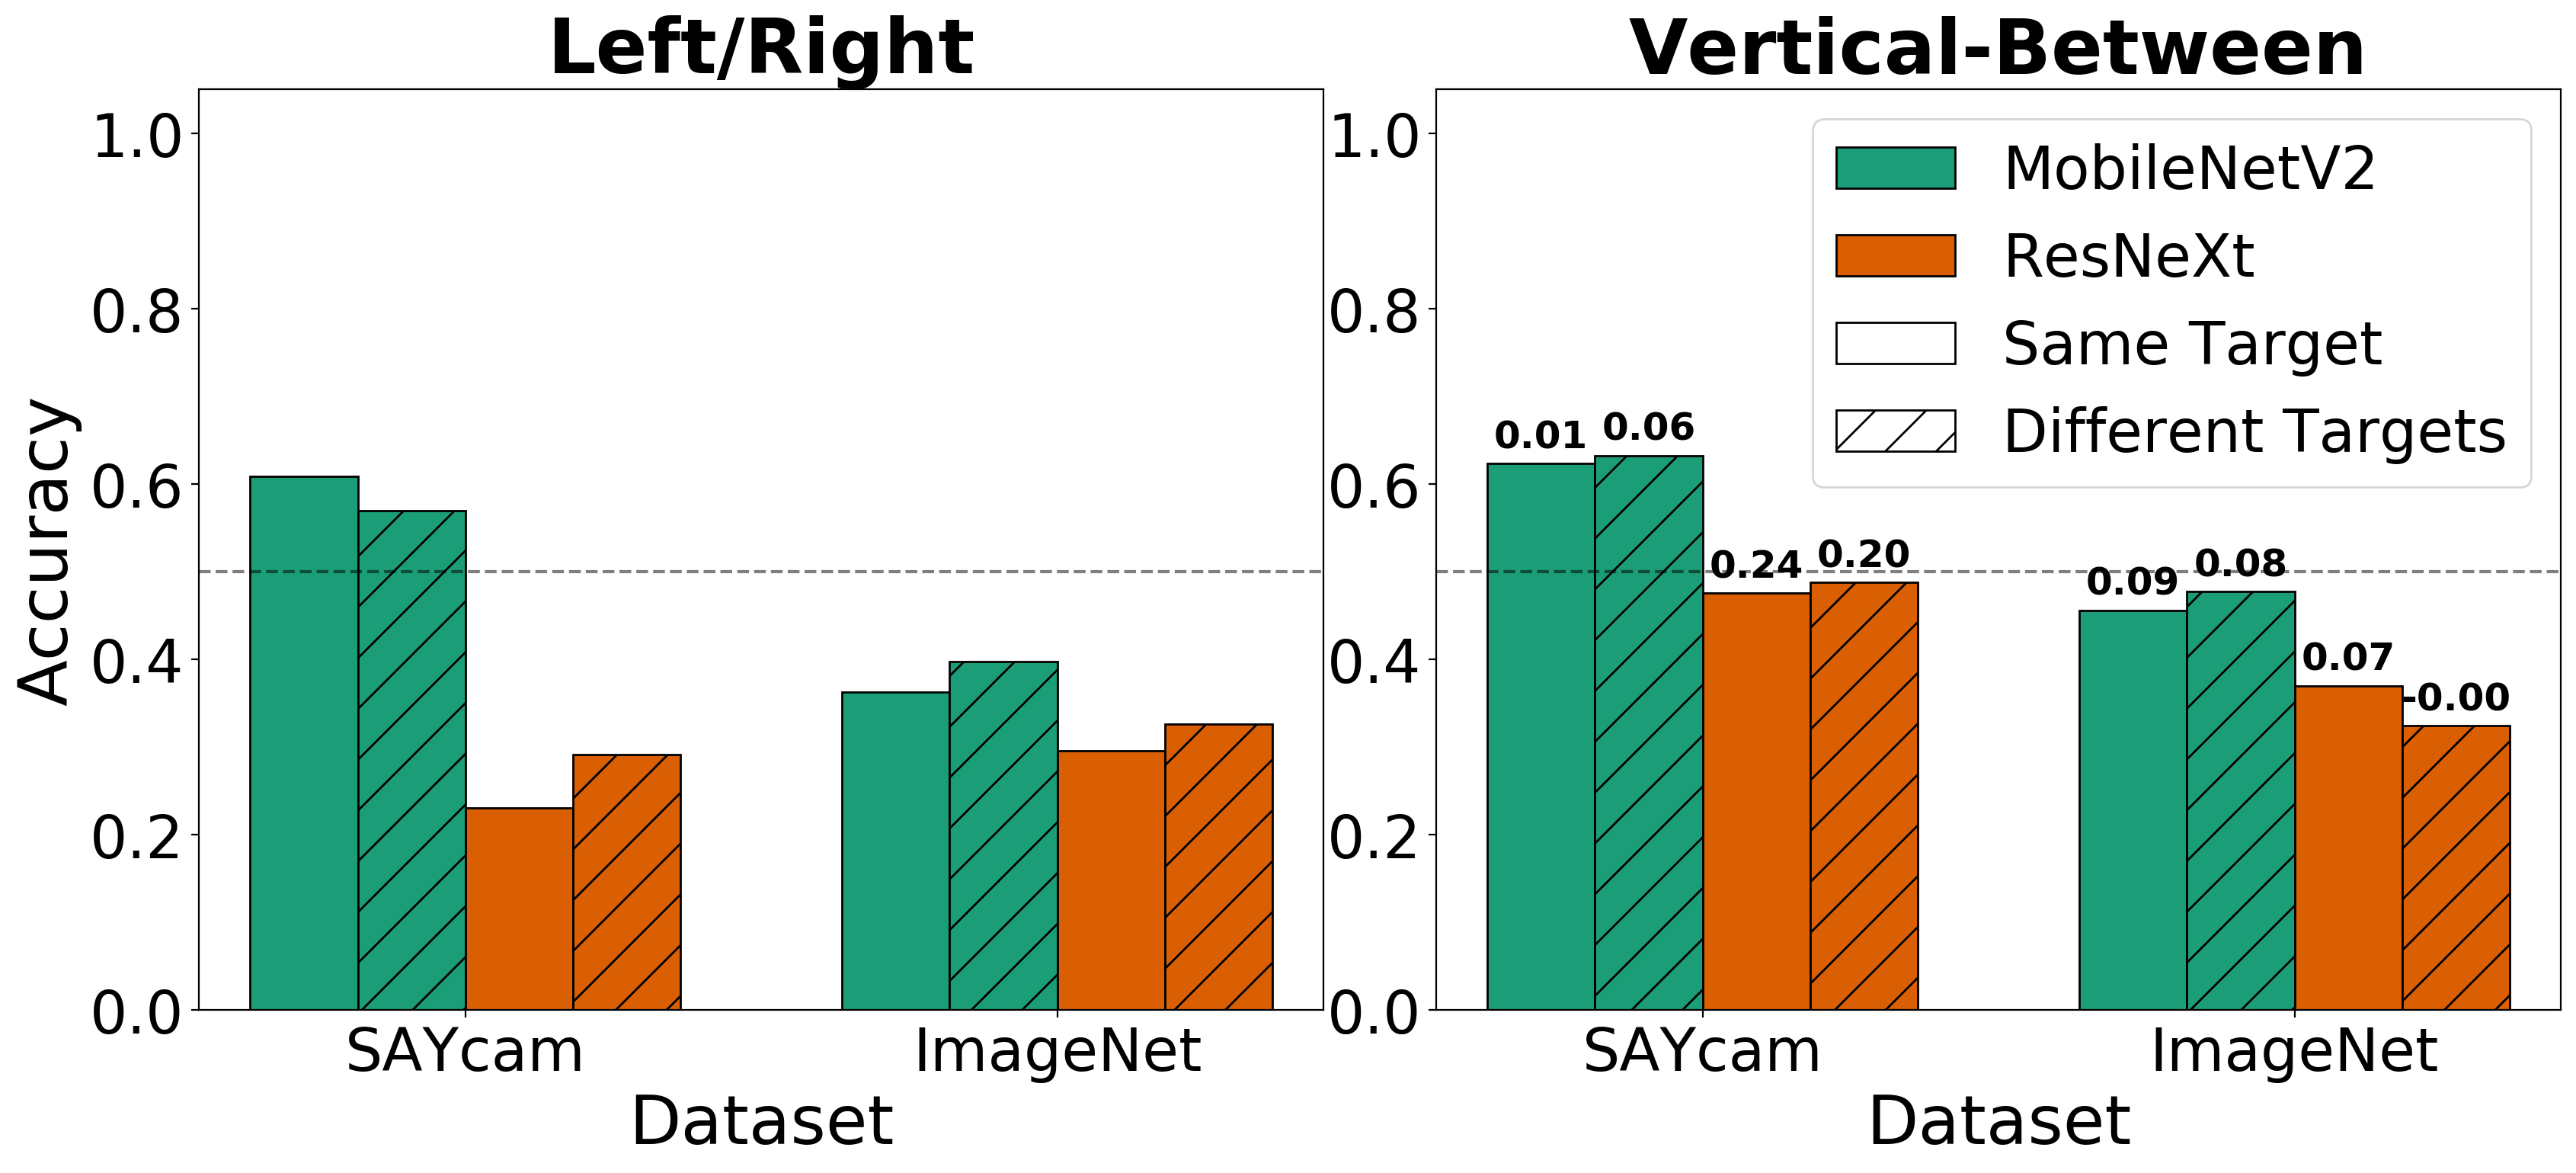

In [277]:
fig = plt.figure(figsize=(20, 8), dpi=200)
fig.subplots_adjust(wspace=0.1)

text_kwargs = {'fontsize': 32}

left_right_ax = plt.subplot(1, 2, 1)
create_bar_chart(df, 
                 {'relation': 'left_right', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'],
                 legend_loc='lower right', plot_std=False,
                 title='Left/Right', legend=False,
                 text_kwargs=text_kwargs, bar_spacing=0.3, 
                 title_kwargs=dict(fontweight='bold'),
                 ax=left_right_ax)

vertical_between_ax = plt.subplot(1, 2, 2)
create_bar_chart(df, 
                 {'relation': 'vertical_between', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'],
                 legend_loc='upper right', plot_std=False,
                 title='Vertical-Between', ylabel='',
                 text_kwargs=text_kwargs, bar_spacing=0.3, legend_ncol=1,
                 above_bar_texts=vertical_mean_diff.acc_mean,
                 above_bar_text_spacing=0.03, above_bar_text_fontsize=18,
                 title_kwargs=dict(fontweight='bold'),
                 ax=vertical_between_ax)

save_plot('exp2_vertical_reference_bar_charts.pdf')

plt.show()

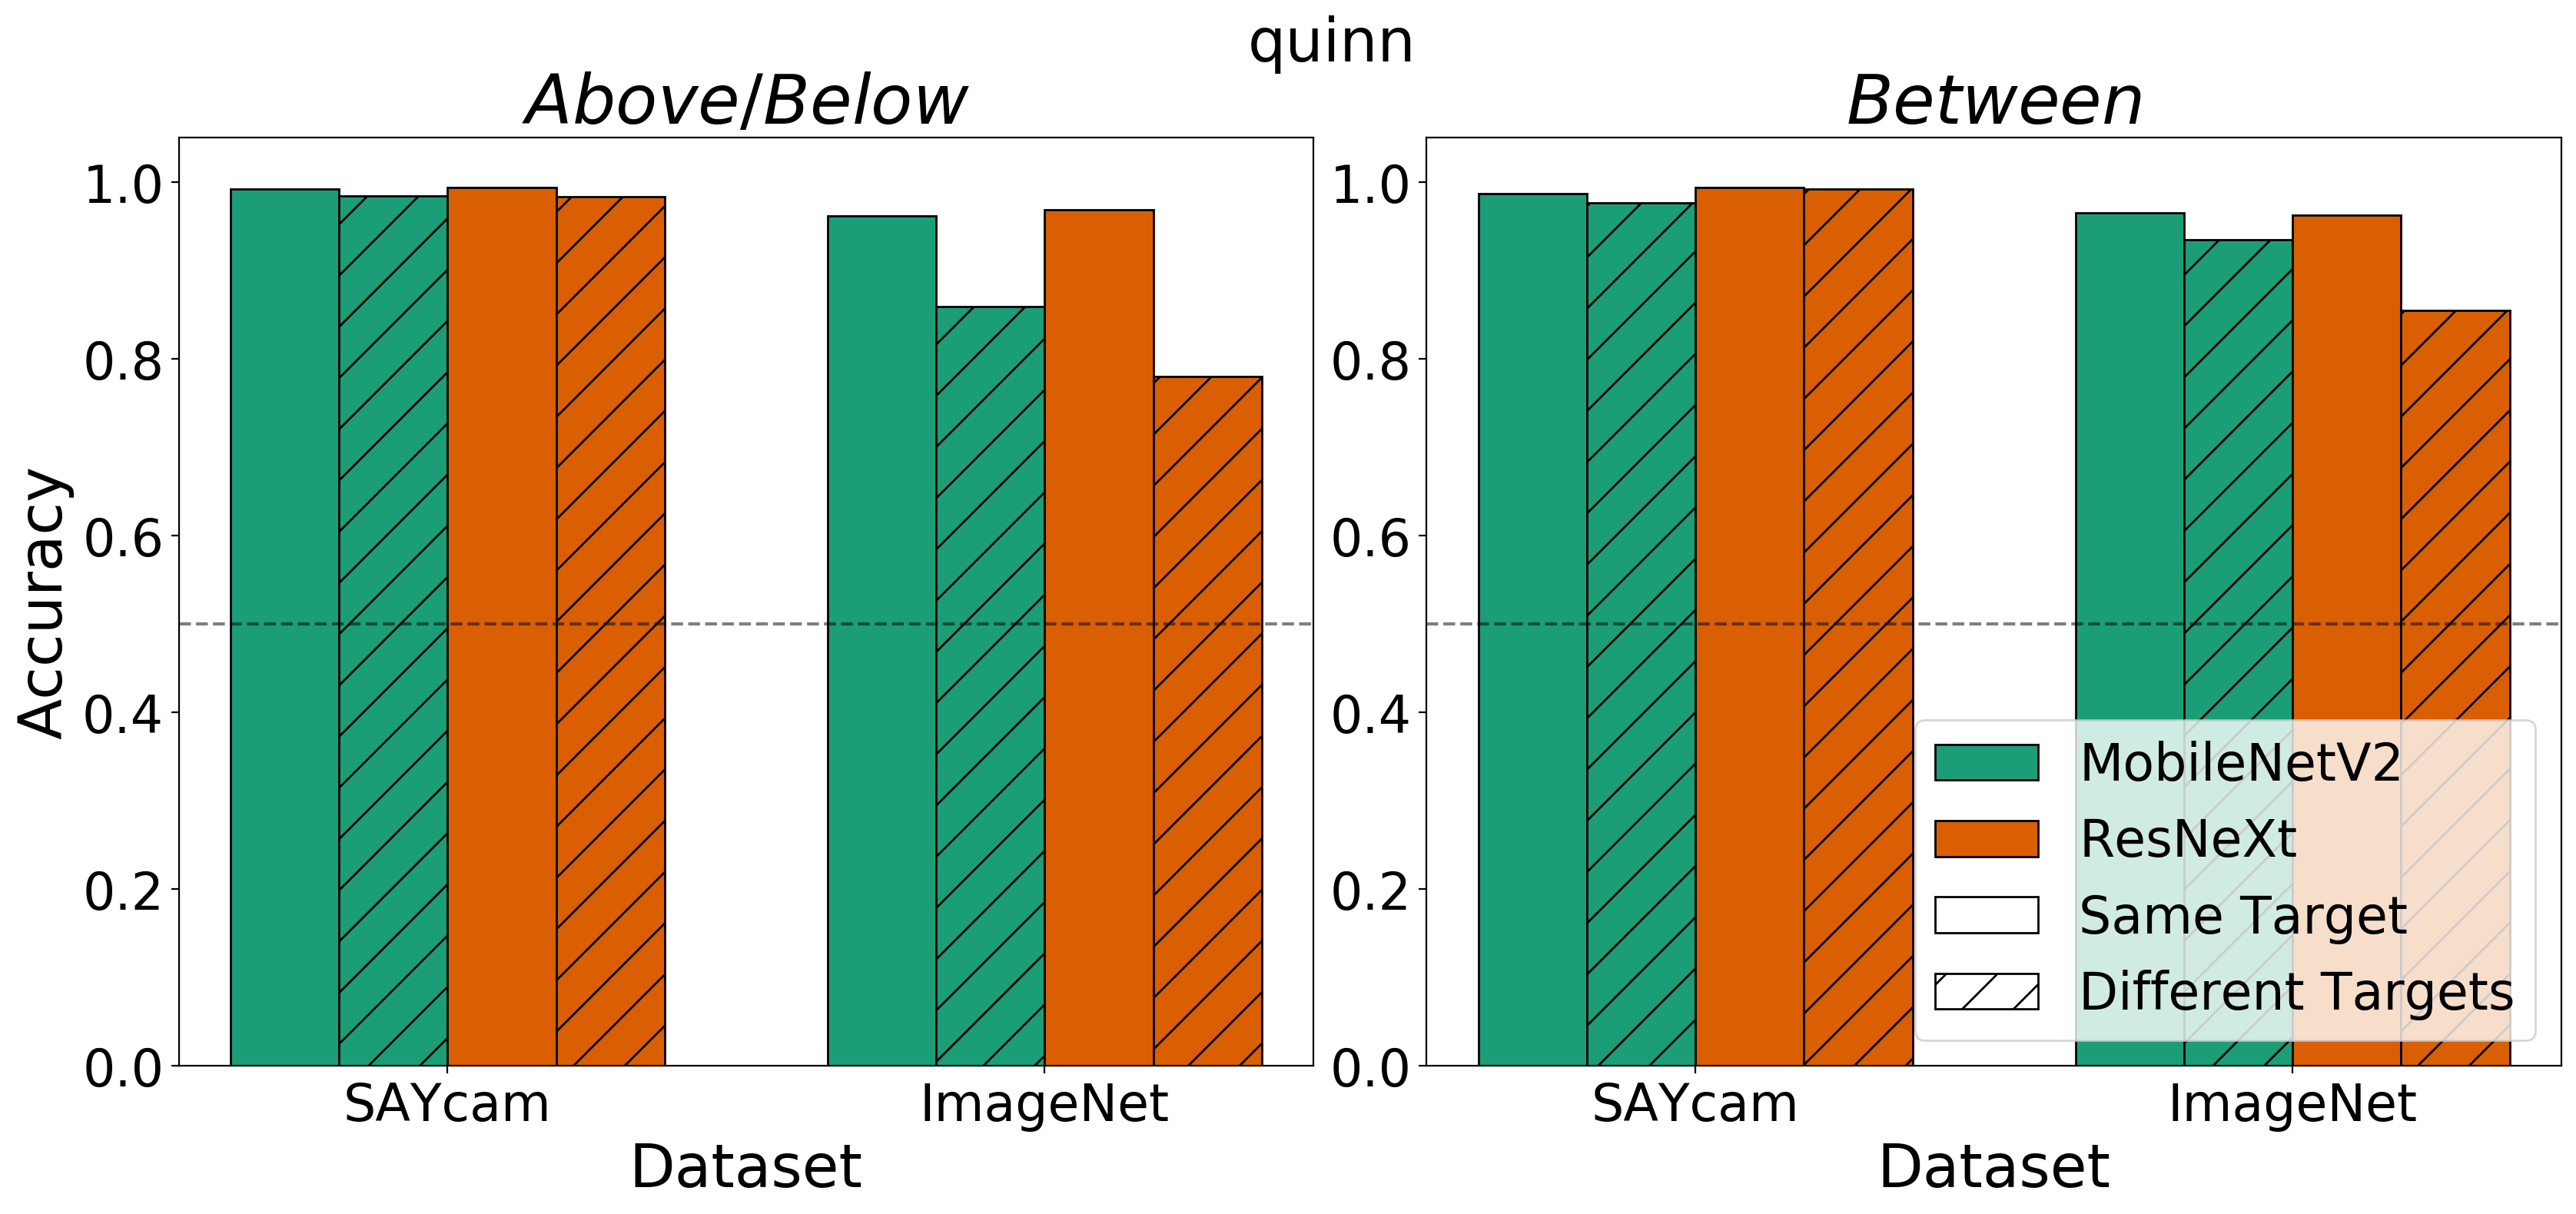

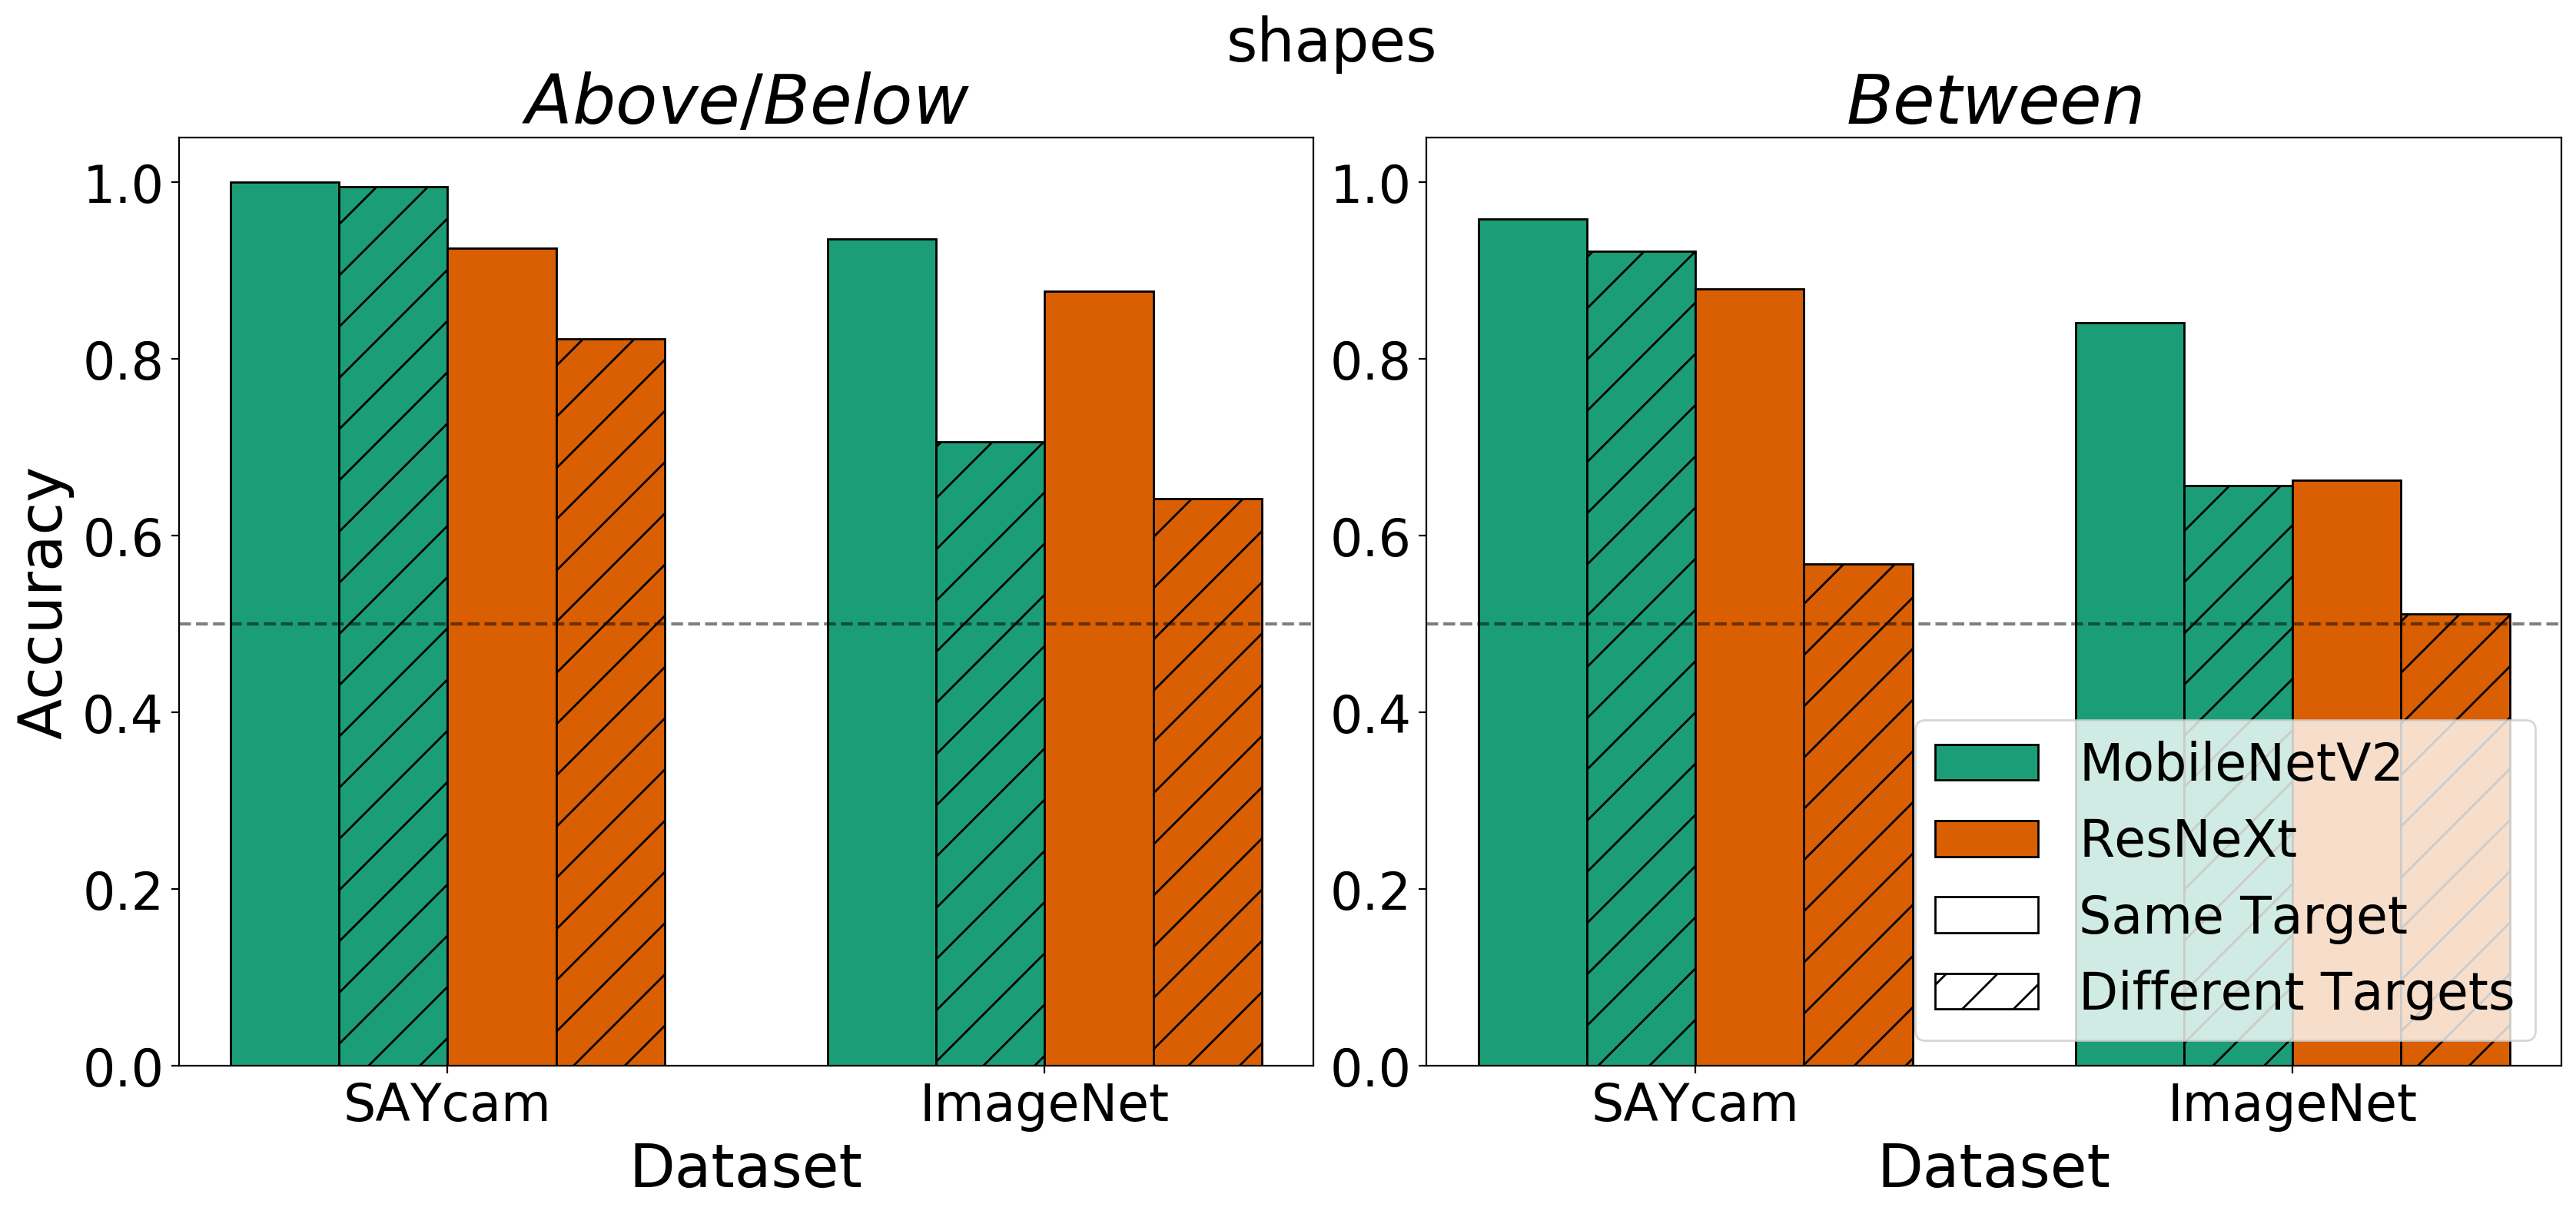

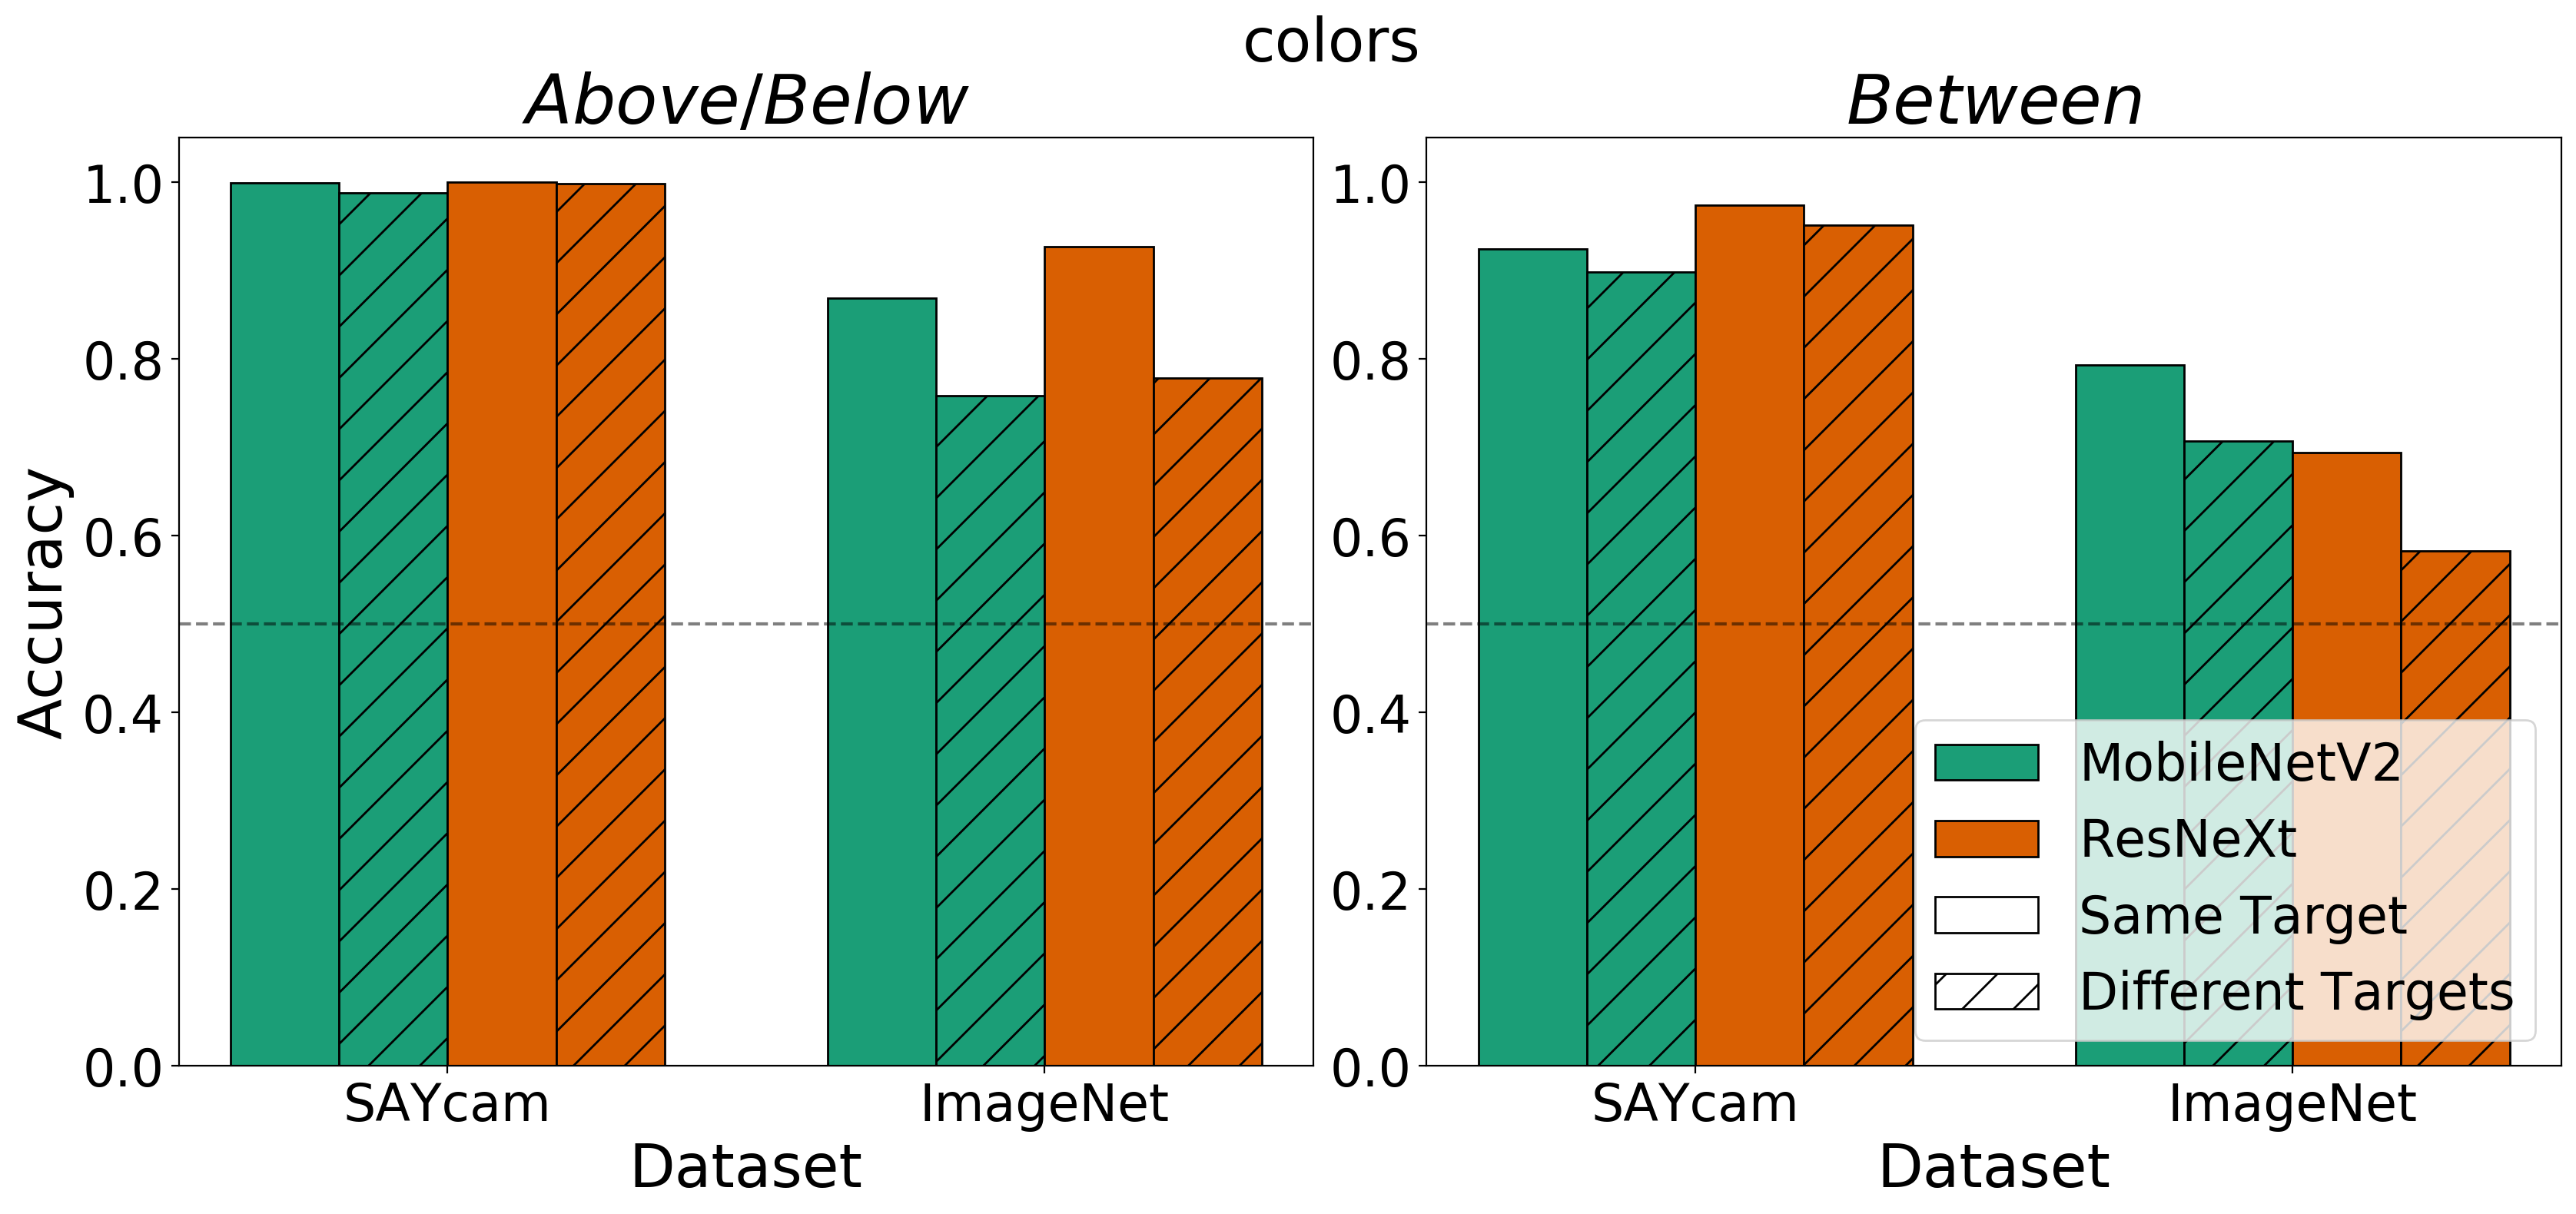

In [153]:
for rendering in df.rendering.unique():
    fig = plt.figure(figsize=(20, 8), dpi=200)
    fig.subplots_adjust(wspace=0.1)

    text_kwargs = {'fontsize': 28}
    
    plt.suptitle(rendering, **text_kwargs)

    above_below_ax = plt.subplot(1, 2, 1)
    create_bar_chart(df, 
                     {'relation': 'above_below', 'dataset': ['saycam', 'imagenet'], 
                      'rendering': rendering}, 
                     ['dataset', 'model_name', 'n_target_types'],
                     legend_loc='lower right', plot_std=False,
                     title='$\\it{Above/Below}$', legend=False,
                     text_kwargs=text_kwargs, bar_spacing=0.3, 
                     ax=above_below_ax)

    between_ax = plt.subplot(1, 2, 2)
    create_bar_chart(df, 
                     {'relation': 'between', 'dataset': ['saycam', 'imagenet'],
                      'rendering': rendering}, 
                     ['dataset', 'model_name', 'n_target_types'],
                     legend_loc='lower right', plot_std=False,
                     title='$\\it{Between}$', ylabel='', legend_ncol=1,
                     text_kwargs=text_kwargs, bar_spacing=0.3,
                     ax=between_ax)

    plt.show()

# Recover min and max for untrained models

In [95]:
filter_and_group(df, {'dataset': 'random'}, ['model_name']).acc_mean.describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
mobilenet,24.0,0.47959,0.044461,0.377930,0.459473,0.497070,0.509033,0.532617
resnext,24.0,0.54943,0.060627,0.405273,0.515771,0.558545,0.583569,0.665039


# Visualizing example objects

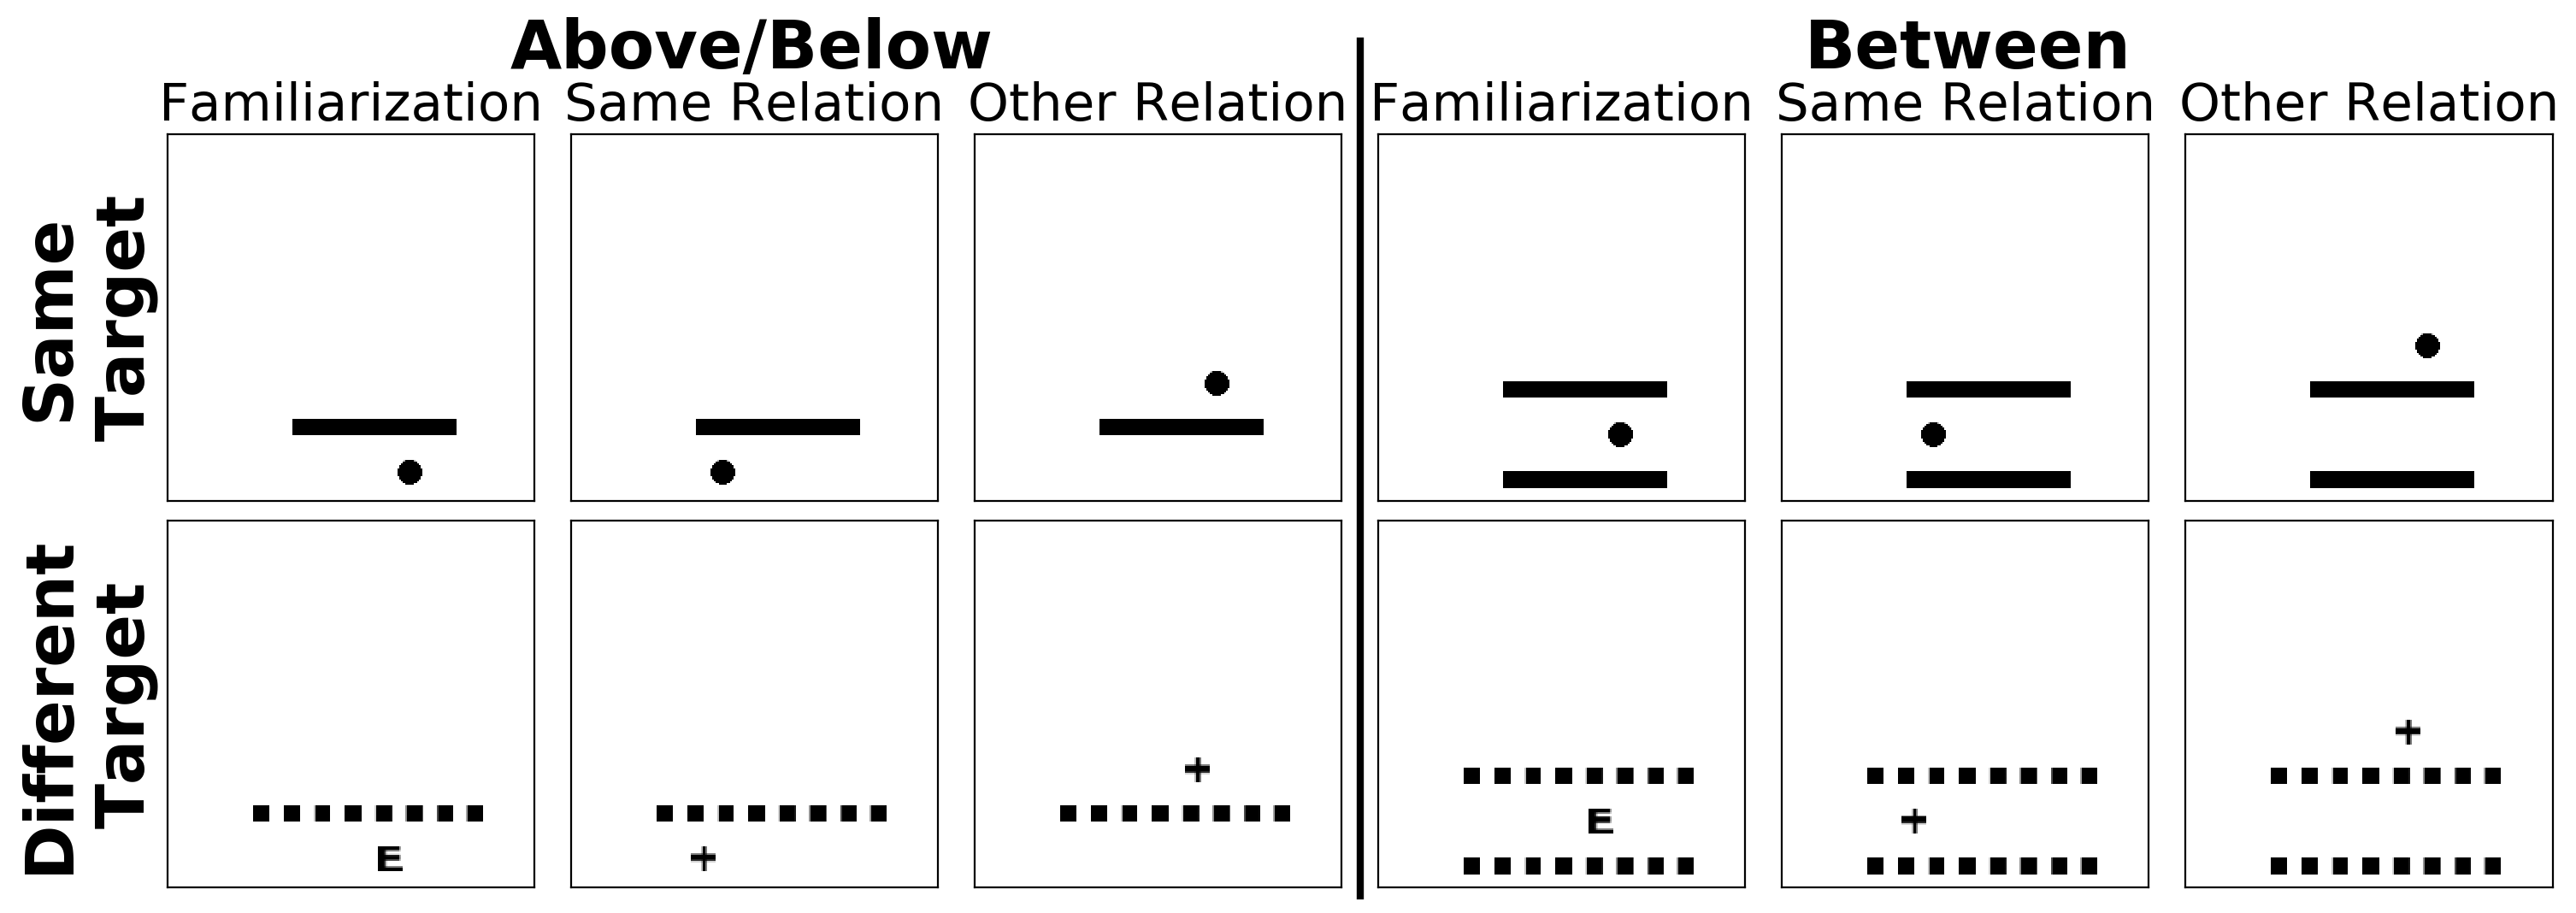

In [267]:
dot_and_bar_names, dot_and_bar_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, dot_and_bar_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Dot-and-Bar'))

triplet_generator_lists = (dot_and_bar_triplet_generators,
                           quinn_split_reference_text_triplet_generators, )

row_labels = ('Same\nTarget', 'Different\nTarget')

N_rows = len(triplet_generator_lists)

baseline_font_size = 28
side_rendering_labels = True
N = 5

fig = plt.figure(figsize=(18, 2.5 * N_rows), dpi=200)

row = 0
for triplet_generator_list in triplet_generator_lists:
    col = 0
    for trip_gen in triplet_generator_list:
        if trip_gen.n_target_types == 2 and not trip_gen.transpose:
            triplet = trip_gen(N, normalize=False)[-1]
            for sub_col in range(3):
                ax = plt.subplot(N_rows, 6, (row * 6) + (col * 3) + sub_col + 1)
                ax.imshow(triplet[sub_col].permute(1, 2, 0).numpy())
                ax.get_xaxis().set_ticks([])
                ax.get_yaxis().set_ticks([])
                if row == 0:
                    if sub_col == 0:
                        ax.set_title('Familiarization', fontsize=baseline_font_size - 6)
                    elif sub_col == 1:
                        ax.set_title('Same Relation', fontsize=baseline_font_size - 6)
                    else:
                        ax.set_title('Other Relation', fontsize=baseline_font_size - 6)
                if side_rendering_labels:
                    if col == 0 and sub_col == 0:
                        ax.set_ylabel(row_labels[row], fontsize=baseline_font_size, fontweight='bold')
            
            col += 1
        
    row += 1
        
fig.text(0.315, .99, 'Above/Below', fontsize=baseline_font_size, fontweight='bold',
        horizontalalignment='center', verticalalignment='center',)

fig.text(0.71, .99, 'Between', fontsize=baseline_font_size, fontweight='bold',
        horizontalalignment='center', verticalalignment='center',)

fig.subplots_adjust(wspace=0.1, hspace=0.01, bottom=0, top=0.9)
l1 = matplotlib.lines.Line2D([0.5125, 0.5125], [0, 1], transform=fig.transFigure, figure=fig, 
                             color='black', lw=3, ls='-')
    

fig.lines.append(l1)

save_plot(f'intro_example_stimuli.pdf')

plt.show()

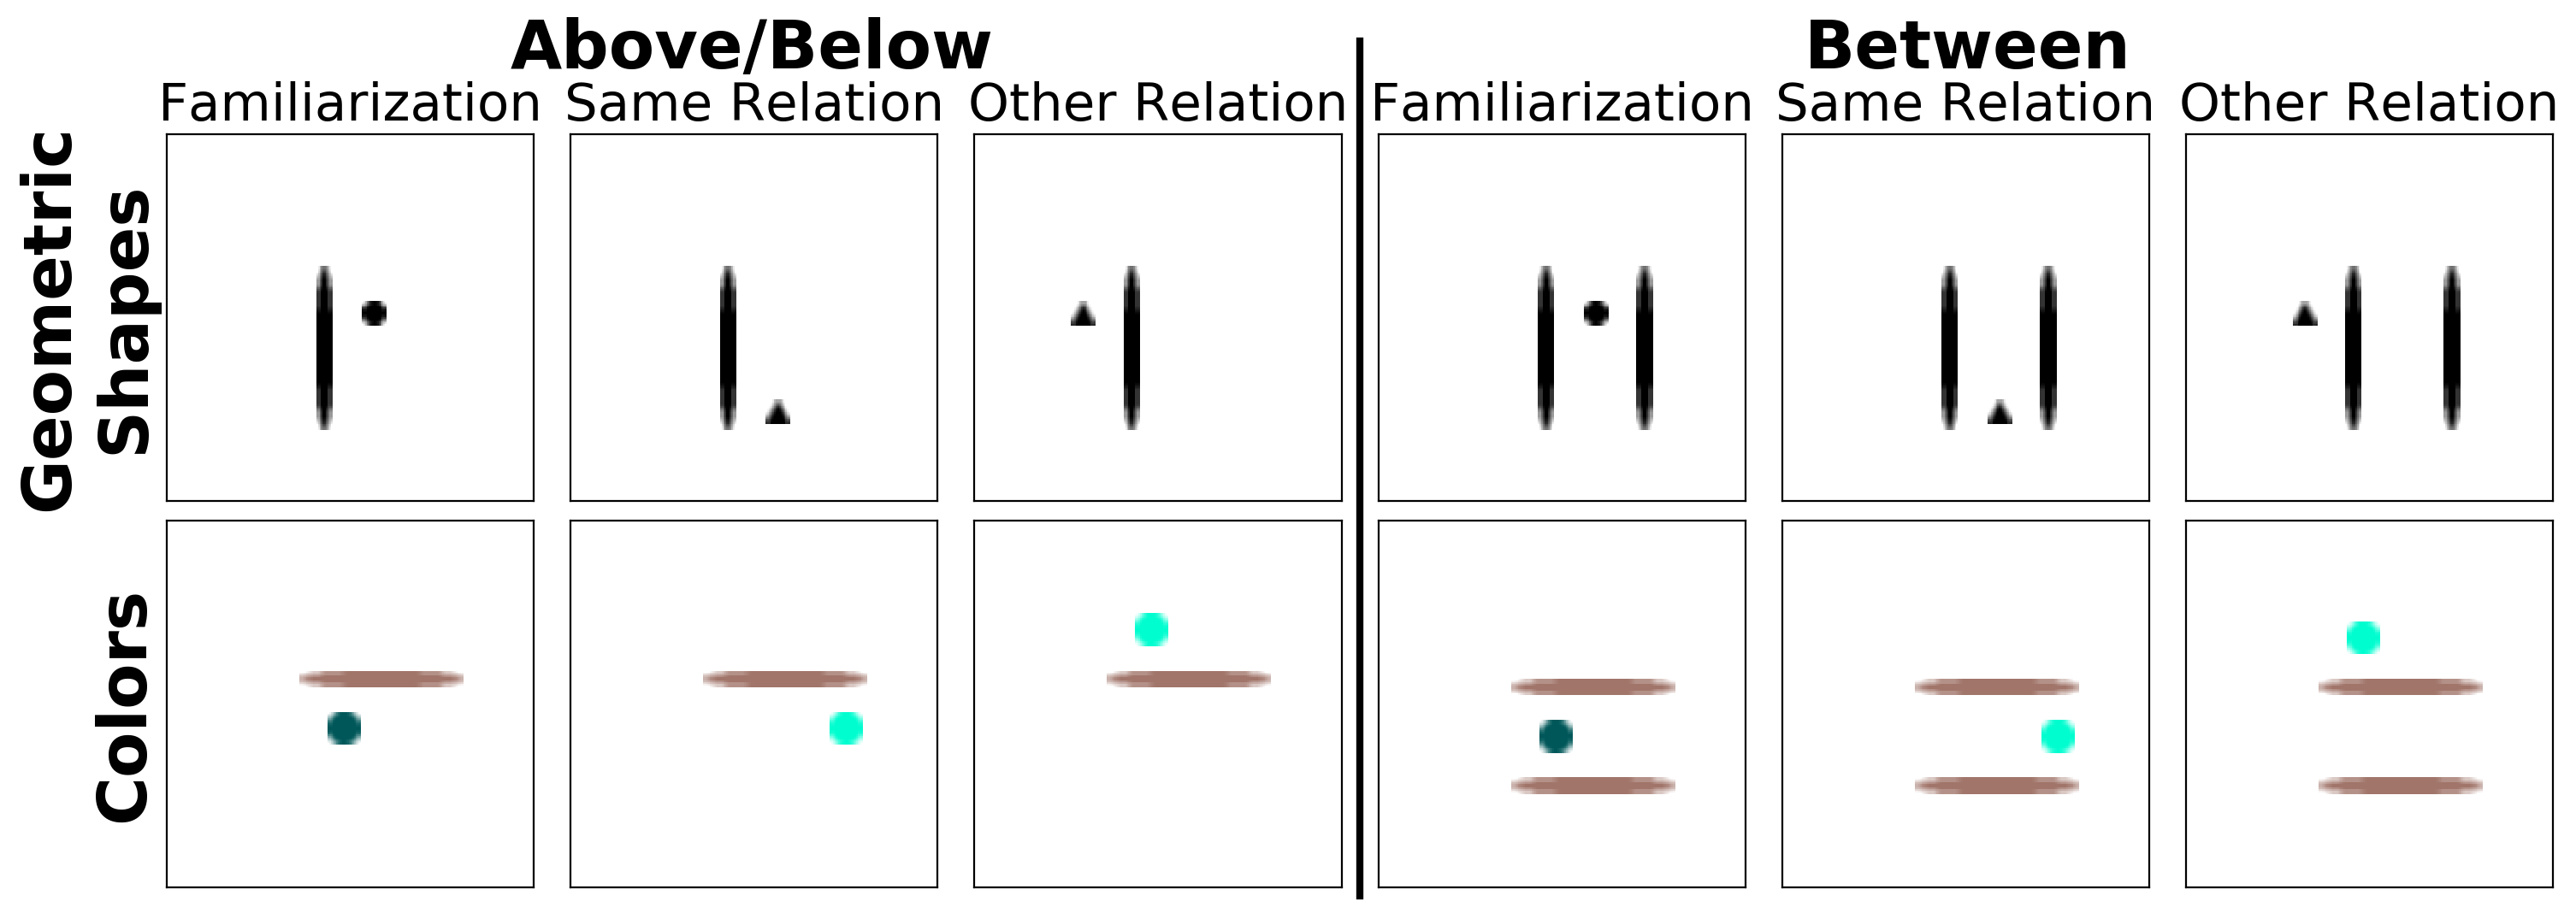

In [268]:
c = 23
rng = np.random.default_rng(c)
random_gen = build_random_color_stimulus_generator(rng)

random_color_names, random_color_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, random_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Random-Color'))

triplet_generator_lists = (quinn_different_shape_triplet_generators,
                           random_color_triplet_generators)
row_labels = ('Geometric\nShapes', 'Colors')
N_rows = len(triplet_generator_lists)

baseline_font_size = 28
side_rendering_labels = True
N = 13

fig = plt.figure(figsize=(18, 2.5 * N_rows), dpi=200)

row = 0
for triplet_generator_list in triplet_generator_lists:
    col = 0
    for trip_gen in triplet_generator_list:
        if trip_gen.n_target_types == 2 and trip_gen.transpose != (row % 2):
            triplet = trip_gen(N, normalize=False)[-1]
            for sub_col in range(3):
                ax = plt.subplot(N_rows, 6, (row * 6) + (col * 3) + sub_col + 1)
                ax.imshow(triplet[sub_col].permute(1, 2, 0).numpy())
                ax.get_xaxis().set_ticks([])
                ax.get_yaxis().set_ticks([])
                if row == 0:
                    if sub_col == 0:
                        ax.set_title('Familiarization', fontsize=baseline_font_size - 6)
                    elif sub_col == 1:
                        ax.set_title('Same Relation', fontsize=baseline_font_size - 6)
                    else:
                        ax.set_title('Other Relation', fontsize=baseline_font_size - 6)
                if side_rendering_labels:
                    if col == 0 and sub_col == 0:
                        ax.set_ylabel(row_labels[row], fontsize=baseline_font_size, fontweight='bold')
                        
            
            col += 1
        
    row += 1
        
fig.text(0.315, .99, 'Above/Below', fontsize=baseline_font_size, fontweight='bold',
        horizontalalignment='center', verticalalignment='center',)

fig.text(0.71, .99, 'Between', fontsize=baseline_font_size, fontweight='bold',
        horizontalalignment='center', verticalalignment='center',)

fig.subplots_adjust(wspace=0.1, hspace=0.01, bottom=0, top=0.9)
l1 = matplotlib.lines.Line2D([0.5125, 0.5125], [0, 1], transform=fig.transFigure, figure=fig, 
                         color='black', lw=3, ls='-')
    

fig.lines.append(l1)

save_plot(f'exp2_example_stimuli_{side_rendering_labels and "side_rendering_labels" or "top_rendering_labels"}.pdf')

plt.show()